# GOOGLE COLAB MOUNTING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Group5_AI4C

/content/drive/MyDrive/AI4C


# IMPORTS

In [ ]:
%pip install -q tensorflow==2.9.2
%pip install adversarial-robustness-toolbox[all]
%pip install h5py==2.10.0
%pip install Pillow
%pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 KB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 KB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    U

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
import h5py
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.disable_eager_execution()
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pickle
# Audio model
from model import SpeakerID
# ART

import art
from art import config
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool, CarliniL2Method
from art.defences.trainer import AdversarialTrainer

#Tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
#Sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

#import cv2
import random
from tqdm import tqdm

print("\nTensorflow Version: " + tf.__version__)

print("ART Version: " + art.__version__)

print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



Tensorflow Version: 2.9.2
ART Version: 1.13.0
GPU Available:  True


# LOADING DATA

## LOADING TARGET CLASS AUDIOS

In [ ]:
class Target:
  def __init__(self, label='id10300', numaudios=304):
    self.numaudios = numaudios
    self.label = label
  
target=Target()

## LOADING DATASETS

In [ ]:
filename = 'Datasets/dataset.h5'
with h5py.File(filename, 'r') as hf:
    X_def = hf['audios'][...]
    y_def = hf['labels'][...]

print(X_def.shape , y_def.shape)

(616, 130118) (616,)


In [ ]:
filename = 'Datasets/dataset_adv.h5'
with h5py.File(filename, 'r') as hf:
    X_def_adv = hf['audios'][...]
    y_def_adv = hf['labels'][...]

print(X_def_adv.shape , y_def_adv.shape)

(78, 130118) (78,)


## SETTING LABELS

In [ ]:
for i in range(0,len(y_def)):
    if y_def[i]==target.label:
        y_def[i]=1 
    else:
        y_def[i]=0

for i in range(0,len(y_def_adv)):
    if y_def_adv[i]==target.label:
        y_def_adv[i]=1 
    else:
        y_def_adv[i]=0

## PREPROCESSING AUDIOS

In [ ]:
X_pre = []
for x in X_def:
    x = np.expand_dims(x, -1)
    X_pre.append(x)

X_def = np.array(X_pre)
del X_pre
print(X_def.shape, y_def.shape)

(616, 130118, 1) (616,)


In [ ]:
X_pre = []
for x in X_def_adv:
    x = np.expand_dims(x, -1)
    X_pre.append(x)

X_def_adv = np.array(X_pre)
del X_pre
print(X_def_adv.shape, y_def_adv.shape)

(78, 130118, 1) (78,)


## SETS SPLITTING

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_def, y_def, test_size=0.3, random_state=42)
X_test = X_def_adv
y_test = y_def_adv

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(431, 130118, 1) (431,)
(185, 130118, 1) (185,)


In [ ]:
# Configuration options
num_classes = 2

# Convert target classes to categorical ones
Y_train_cat = to_categorical(y_train, num_classes)
Y_val_cat = to_categorical(y_val, num_classes)
Y_test_cat = to_categorical(y_test, num_classes)

# UTILITIES

In [ ]:
def one_hot(a, n):
  e=np.eye(n) 
  result=e[a]
  return result

def de_one_hot(y):
  return np.argmax(y, axis=1)
  
def order_list_take_indices(principal):
  ordered = principal[:]
  ordered.sort()
  indices = []
  for i in range(len(ordered)):
    for k in range(len(principal)):
      if ordered[i]==principal[k]:
        indices.append(k)
        continue
  return ordered, indices

def order_on_indices(indices, toorder):
  ordered = []
  for i in range(len(toorder)):
    ordered.append(toorder[indices[i]])
  return ordered

def calculate_accuracy(prediction, true):
  dim = len(true)
  count = 0
  for i in range(len(true)):
    if prediction[i] == true[i]:
      count+=1
  return count/dim 

# LOADING FEATURE EXTRACTOR

In [ ]:
input_shape = (None, 1)
checkpoint_path = 'resnet18_mel_25_10_norm.h5'
SpeakerId = SpeakerID(input_shape, checkpoint_path, n_classes=1251)

In [ ]:
resnet = SpeakerId.layers[-1] #ResNet part of the SpeakerID
X = resnet.layers[-3].output  #Cut from GlobalAverage
customModel = Model(inputs = resnet.input, outputs = X)
y = customModel(SpeakerId.layers[-2].output)
SpeakerId = Model(inputs=SpeakerId.input, outputs=y) #FinalModel

##EXTRACTING FEATURES

In [ ]:
X_train = SpeakerId.predict(X_train)
X_val = SpeakerId.predict(X_val)
X_test = SpeakerId.predict(X_test)

##NORMALIZATION

In [ ]:
for i in range(len(X_train)):
  X_train[i] = (X_train[i] - X_train[i][np.argmin(X_train[i])]) /  (X_train[i][np.argmax(X_train[i])] - X_train[i][np.argmin(X_train[i])])

for i in range(len(X_val)):
  X_val[i] = (X_val[i] - X_val[i][np.argmin(X_val[i])]) /  (X_val[i][np.argmax(X_val[i])] - X_val[i][np.argmin(X_val[i])])

for i in range(len(X_test)):
  X_test[i] = (X_test[i] - X_test[i][np.argmin(X_test[i])]) /  (X_test[i][np.argmax(X_test[i])] - X_test[i][np.argmin(X_test[i])])

In [ ]:
print(X_train.shape)
print(y_train.shape)

(431, 512)
(431,)


# CLASSIFIERS TRAINING

## WHITE BOX MODEL 

In [ ]:
whiteBox = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation=tf.nn.relu, input_shape=(512, )),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Activation(tf.nn.softmax)
])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
whiteBox.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
whiteBox.fit(X_train, Y_train_cat, validation_data=(X_val, Y_val_cat), epochs=100, batch_size=32, callbacks=[callback], shuffle=True)

print(whiteBox.summary())
accT = whiteBox.evaluate(X_train,Y_train_cat, verbose=0)
predictionT = whiteBox.predict(X_train)
dey_test = de_one_hot(Y_train_cat)
dey_pred = de_one_hot(predictionT)
matrix=confusion_matrix(dey_test, dey_pred)
print('Training set accuracy: '+ str(round(accT[1]*100,3)))
print(matrix, "\n\n")

accV = whiteBox.evaluate(X_val,Y_val_cat, verbose=0)
predictionV = whiteBox.predict(X_val)
dey_test = de_one_hot(Y_val_cat)
dey_pred = de_one_hot(predictionV)
matrix=confusion_matrix(dey_test, dey_pred)
print('Validation set accuracy: '+ str(round(accV[1]*100,3)))
print(matrix, "\n\n")

accT = whiteBox.evaluate(X_test,Y_test_cat, verbose=0)
predictionT = whiteBox.predict(X_test)
dey_test = de_one_hot(Y_test_cat)
dey_pred = de_one_hot(predictionT)
matrix=confusion_matrix(dey_test, dey_pred)
print('Test set accuracy: '+ str(round(accT[1]*100,3)))
print(matrix, "\n\n")

Train on 431 samples, validate on 185 samples
Epoch 1/100
431/431 [==============================] - 1s 2ms/sample - loss: 0.2531 - accuracy: 0.9165 - val_loss: 0.0457 - val_accuracy: 0.9946
Epoch 2/100
431/431 [==============================] - 0s 125us/sample - loss: 0.0203 - accuracy: 0.9977 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 3/100
431/431 [==============================] - 0s 107us/sample - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9946
Epoch 4/100
431/431 [==============================] - 0s 101us/sample - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 5/100
431/431 [==============================] - 0s 99us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 0.9946
Epoch 6/100
431/431 [==============================] - 0s 97us/sample - loss: 7.3648e-04 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9946
Epoch 7/100
431/431 [==============================] - 0s 94us/sample - 

### SAVE WHITE BOX MODEL

In [ ]:
whiteBox.save("models/whiteBox.h5")

## BLACK BOX MODEL 

In [ ]:
blackBox = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation=tf.nn.softmax, input_shape=(512, )),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Activation(tf.nn.softmax)
])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
blackBox.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
blackBox.fit(X_train, Y_train_cat, validation_data=(X_val, Y_val_cat), epochs=100, batch_size=32, callbacks=[callback], shuffle=True)

print(blackBox.summary())
accT = blackBox.evaluate(X_train,Y_train_cat, verbose=0)
predictionT = blackBox.predict(X_train)
dey_test = de_one_hot(Y_train_cat)
dey_pred = de_one_hot(predictionT)
matrix=confusion_matrix(dey_test, dey_pred)
print('Training set accuracy: '+ str(round(accT[1]*100,3)))
print(matrix, "\n\n")

accV = blackBox.evaluate(X_val,Y_val_cat, verbose=0)
predictionV = blackBox.predict(X_val)
dey_test = de_one_hot(Y_val_cat)
dey_pred = de_one_hot(predictionV)
matrix=confusion_matrix(dey_test, dey_pred)
print('Validation set accuracy: '+ str(round(accV[1]*100,3)))
print(matrix, "\n\n")

accT = blackBox.evaluate(X_test,Y_test_cat, verbose=0)
predictionT = blackBox.predict(X_test)
dey_test = de_one_hot(Y_test_cat)
dey_pred = de_one_hot(predictionT)
matrix=confusion_matrix(dey_test, dey_pred)
print('Test set accuracy: '+ str(round(accT[1]*100,3)))
print(matrix, "\n\n")

Train on 431 samples, validate on 185 samples
Epoch 1/100
431/431 [==============================] - 1s 2ms/sample - loss: 0.6291 - accuracy: 0.7425 - val_loss: 0.5815 - val_accuracy: 0.9946
Epoch 2/100
431/431 [==============================] - 0s 111us/sample - loss: 0.5442 - accuracy: 0.9768 - val_loss: 0.5084 - val_accuracy: 0.9946
Epoch 3/100
431/431 [==============================] - 0s 98us/sample - loss: 0.4803 - accuracy: 0.9954 - val_loss: 0.4526 - val_accuracy: 0.9892
Epoch 4/100
431/431 [==============================] - 0s 102us/sample - loss: 0.4328 - accuracy: 0.9954 - val_loss: 0.4149 - val_accuracy: 0.9946
Epoch 5/100
431/431 [==============================] - 0s 99us/sample - loss: 0.3989 - accuracy: 1.0000 - val_loss: 0.3857 - val_accuracy: 0.9946
Epoch 6/100
431/431 [==============================] - 0s 120us/sample - loss: 0.3746 - accuracy: 1.0000 - val_loss: 0.3649 - val_accuracy: 0.9946
Epoch 7/100
431/431 [==============================] - 0s 96us/sample - loss

### SAVE BLACK BOX MODEL

In [ ]:
blackBox.save("models/blackBox.h5")

#LOAD MODELS

## WHITE BOX MODEL LOADING  


In [ ]:
whiteBox = tf.keras.models.load_model("models/whiteBox.h5")

## BLACK BOX MODEL LOADING 


In [ ]:
blackBox = tf.keras.models.load_model("models/blackBox.h5")

# ATTACKS

## FGSM

In [ ]:
# Create a ART Keras classifier for the TensorFlow Keras model.
classifier_fgsm = KerasClassifier(model=whiteBox, clip_values=(0, 1), use_logits=False)

In [ ]:
e = [0,0.01,0.02,0.03,0.04,0.05,0.07,0.08,0.09,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3]

target_class_fgsm = 1
attack_classes_fgsm = 2
atk_acc_WB = []
net_acc_WB = []
atk_acc_BB = []
net_acc_BB = []

dey_test = de_one_hot(Y_test_cat)
targeted_labels_fgsm = target_class_fgsm*np.ones(y_test.size)
one_hot_targeted_labels_fgsm = tf.keras.utils.to_categorical(targeted_labels_fgsm, num_classes=attack_classes_fgsm)

for epsilon in e:
  print("\n-------------------------------------------------------\n\tepsilon: " + str(epsilon))
  attack_fgsm = FastGradientMethod(estimator=classifier_fgsm, eps=epsilon, targeted=True)
  test_audios_adv_fgsm = attack_fgsm.generate(X_test, one_hot_targeted_labels_fgsm)

  perturbation = np.mean(np.abs((test_audios_adv_fgsm - X_test)))
  print('Average perturbation: {:4.4f}'.format(perturbation))

  print("\n\t\tWhiteBox")
  loss_test, accuracy_test = whiteBox.evaluate(test_audios_adv_fgsm, Y_test_cat, verbose=False)
  net_acc_WB.append(accuracy_test)
  print('Accuracy on adversarial test data:',accuracy_test)
  
  
  targeted_attack_loss, targeted_attack_accuracy = whiteBox.evaluate(test_audios_adv_fgsm, one_hot_targeted_labels_fgsm, verbose=False)
  atk_acc_WB.append(targeted_attack_accuracy)
  print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')


  print("\t\tBlackBox")
  loss_test, accuracy_test = blackBox.evaluate(test_audios_adv_fgsm, Y_test_cat, verbose=False)
  net_acc_BB.append(accuracy_test)
  print('Accuracy on adversarial test data:',accuracy_test)
  
  targeted_attack_loss, targeted_attack_accuracy = blackBox.evaluate(test_audios_adv_fgsm, one_hot_targeted_labels_fgsm, verbose=False)
  atk_acc_BB.append(targeted_attack_accuracy)
  print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')


-------------------------------------------------------
	epsilon: 0
Average perturbation: 0.0000

		WhiteBox
Accuracy on adversarial test data: 1.0
Targeted attack accuracy: 0.00 

		BlackBox
Accuracy on adversarial test data: 1.0
Targeted attack accuracy: 0.00 


-------------------------------------------------------
	epsilon: 0.01
Average perturbation: 0.0097

		WhiteBox
Accuracy on adversarial test data: 0.98717946
Targeted attack accuracy: 0.01 

		BlackBox
Accuracy on adversarial test data: 0.98717946
Targeted attack accuracy: 0.01 


-------------------------------------------------------
	epsilon: 0.02
Average perturbation: 0.0192

		WhiteBox
Accuracy on adversarial test data: 0.96153843
Targeted attack accuracy: 0.04 

		BlackBox
Accuracy on adversarial test data: 0.96153843
Targeted attack accuracy: 0.04 


-------------------------------------------------------
	epsilon: 0.03
Average perturbation: 0.0284

		WhiteBox
Accuracy on adversarial test data: 0.94871795
Targeted att

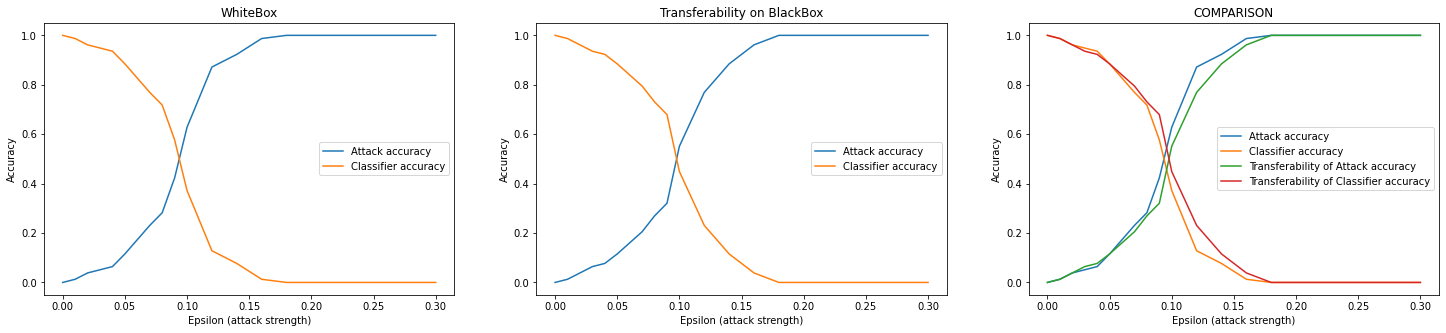

In [ ]:
f = plt.figure(figsize=(25, 5))
#--------WhiteBox-----------
f.add_subplot(1, 3, 1)
plt.plot(e,atk_acc_WB)
plt.plot(e,net_acc_WB)
plt.ylabel("Accuracy")
plt.xlabel("Epsilon (attack strength)")
plt.title("WhiteBox")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)

#--------BlackBox-----------
f.add_subplot(1, 3, 2)
plt.plot(e,atk_acc_BB)
plt.plot(e,net_acc_BB)
plt.ylabel("Accuracy")
plt.xlabel("Epsilon (attack strength)")
plt.title("Transferability on BlackBox")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)

#--------COMPARISON-----------
f.add_subplot(1, 3, 3)
plt.plot(e,atk_acc_WB)
plt.plot(e,net_acc_WB)
plt.plot(e,atk_acc_BB)
plt.plot(e,net_acc_BB)
plt.ylabel("Accuracy")
plt.xlabel("Epsilon (attack strength)")
plt.title("COMPARISON")
plt.legend(["Attack accuracy", "Classifier accuracy", "Transferability of Attack accuracy", "Transferability of Classifier accuracy"], loc=0, frameon=True)

## BIM

In [ ]:
# Create a ART Keras classifier for the TensorFlow Keras model.
classifier_bim = KerasClassifier(model=whiteBox, clip_values=(0, 1))

In [ ]:
e = 1
epsilon_step = [0.001,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
max_iter = [2,3,5,10]
target_class_bim = 1
attack_classes_bim = 2
atk_acc_WB = []
net_acc_WB = []
atk_acc_BB = []
net_acc_BB = []
perturbs = []

dey_test = de_one_hot(Y_test_cat)
targeted_labels_bim = target_class_bim*np.ones(y_test.size)
one_hot_targeted_labels_bim = tf.keras.utils.to_categorical(targeted_labels_bim, num_classes=attack_classes_bim)

for i in max_iter:
  for j in epsilon_step:
    print("\n-------------------------------------------------------\nepsilon: " + str(j) + "       iterations: " + str(i) )
    attack_bim = BasicIterativeMethod(estimator=classifier_bim, eps=e, eps_step=j, max_iter=i, targeted=True, verbose=False)
    test_audios_adv_bim = attack_bim.generate(X_test, one_hot_targeted_labels_bim)

    perturbation = np.mean(np.abs((test_audios_adv_bim - X_test)))
    print('Average perturbation: {:4.4f}'.format(perturbation))
    print("\n\t\tWhiteBox")
    perturbs.append(perturbation)

    loss_test, accuracy_test = whiteBox.evaluate(test_audios_adv_bim, Y_test_cat, verbose=False)
    net_acc_WB.append(accuracy_test)
    print('Accuracy on adversarial test data:',accuracy_test)

    targeted_attack_loss, targeted_attack_accuracy = whiteBox.evaluate(test_audios_adv_bim, one_hot_targeted_labels_bim, verbose = False)
    atk_acc_WB.append(targeted_attack_accuracy)
    print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')

    print("\t\tBlackBox")
    loss_test, accuracy_test = blackBox.evaluate(test_audios_adv_bim, Y_test_cat, verbose=False)
    net_acc_BB.append(accuracy_test)
    print('Accuracy on adversarial test data:',accuracy_test)
    
    targeted_attack_loss, targeted_attack_accuracy = blackBox.evaluate(test_audios_adv_bim, one_hot_targeted_labels_bim, verbose=False)
    atk_acc_BB.append(targeted_attack_accuracy)
    print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')


-------------------------------------------------------
epsilon: 0.001       iterations: 2
Average perturbation: 0.0020

		WhiteBox
Accuracy on adversarial test data: 1.0
Targeted attack accuracy: 0.00 

		BlackBox
Accuracy on adversarial test data: 1.0
Targeted attack accuracy: 0.00 


-------------------------------------------------------
epsilon: 0.02       iterations: 2
Average perturbation: 0.0355

		WhiteBox
Accuracy on adversarial test data: 0.9358974
Targeted attack accuracy: 0.06 

		BlackBox
Accuracy on adversarial test data: 0.9230769
Targeted attack accuracy: 0.08 


-------------------------------------------------------
epsilon: 0.03       iterations: 2
Average perturbation: 0.0512

		WhiteBox
Accuracy on adversarial test data: 0.8717949
Targeted attack accuracy: 0.13 

		BlackBox
Accuracy on adversarial test data: 0.8717949
Targeted attack accuracy: 0.13 


-------------------------------------------------------
epsilon: 0.04       iterations: 2
Average perturbation: 0

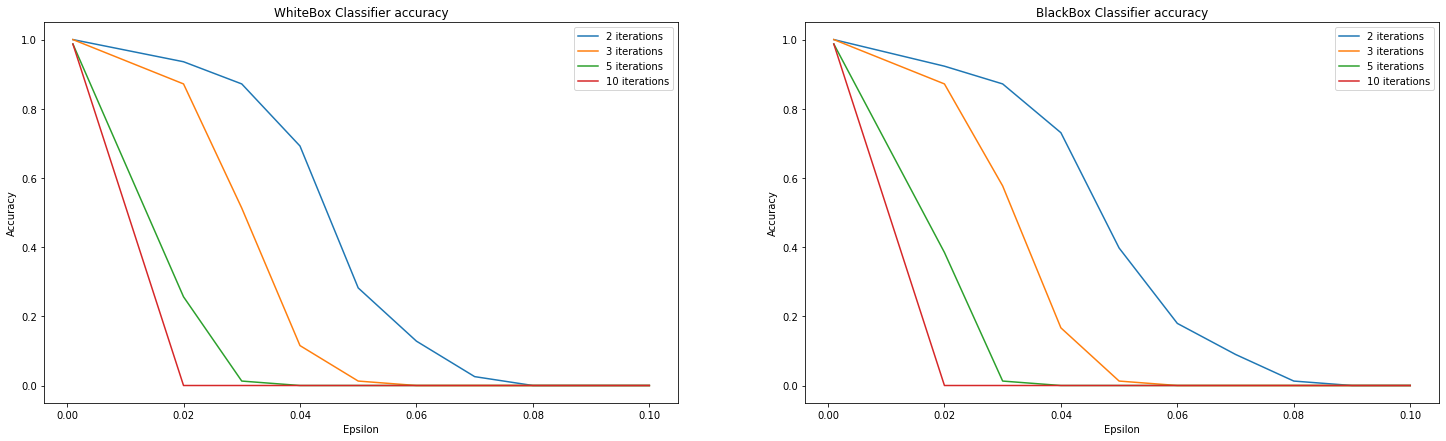

In [ ]:
#----------------WhiteBox----------------------
f = plt.figure(figsize=(25, 7))
f.add_subplot(1, 2, 1)
plt.plot(epsilon_step,net_acc_WB[0:10])
plt.plot(epsilon_step,net_acc_WB[10:20])
plt.plot(epsilon_step,net_acc_WB[20:30])
plt.plot(epsilon_step,net_acc_WB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox Classifier accuracy")
plt.legend(["2 iterations", "3 iterations","5 iterations","10 iterations"], loc=0, frameon=True)

#----------------BlackBox----------------------
f.add_subplot(1, 2, 2)
plt.plot(epsilon_step,net_acc_BB[0:10])
plt.plot(epsilon_step,net_acc_BB[10:20])
plt.plot(epsilon_step,net_acc_BB[20:30])
plt.plot(epsilon_step,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox Classifier accuracy")
plt.legend(["2 iterations", "3 iterations","5 iterations","10 iterations"], loc=0, frameon=True)

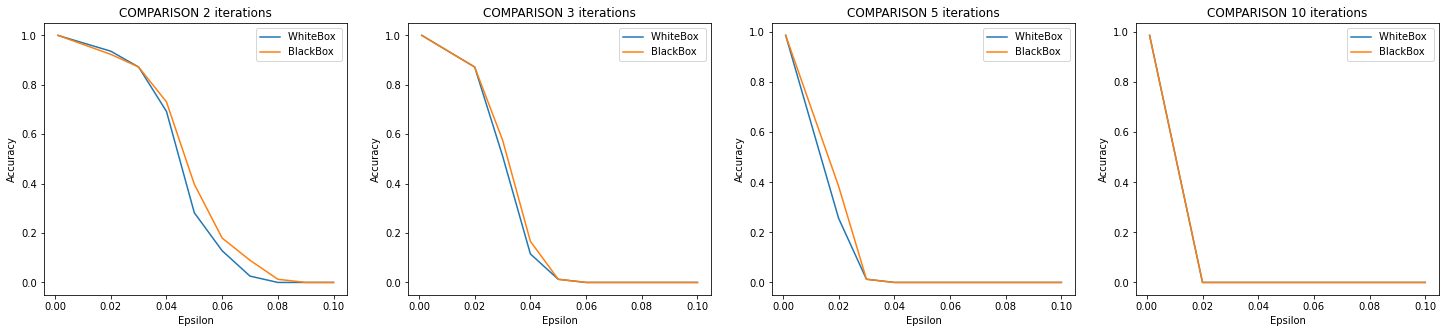

In [ ]:
#-----------COMPARISON------------
f = plt.figure(figsize=(25, 5))
f.add_subplot(1, 4, 1)
plt.plot(epsilon_step,net_acc_WB[0:10])
plt.plot(epsilon_step,net_acc_BB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 2 iterations")
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)
f.add_subplot(1, 4, 2)
plt.plot(epsilon_step,net_acc_WB[10:20])
plt.plot(epsilon_step,net_acc_BB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 3 iterations")
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)
f.add_subplot(1, 4, 3)
plt.plot(epsilon_step,net_acc_WB[20:30])
plt.plot(epsilon_step,net_acc_BB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 5 iterations")
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)
f.add_subplot(1, 4, 4)
plt.plot(epsilon_step,net_acc_WB[30:40])
plt.plot(epsilon_step,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 10 iterations")
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)

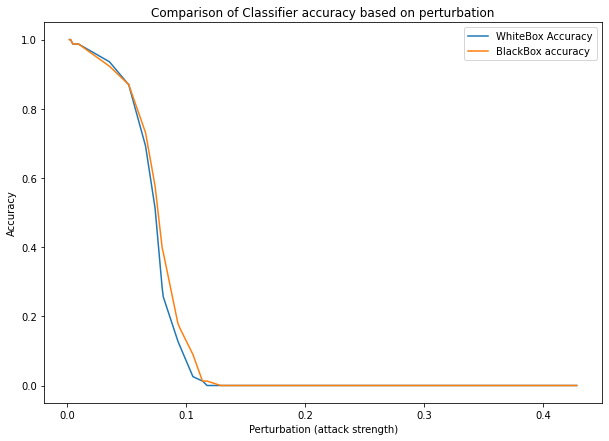

In [ ]:
perturbations, indices = order_list_take_indices(perturbs)
net_acc_WB2 = order_on_indices(indices, net_acc_WB)
net_acc_BB2 = order_on_indices(indices, net_acc_BB)
#--------- Comparison on perturbations -----------
f = plt.figure(figsize=(10, 7))
plt.plot(perturbations, net_acc_WB2)
plt.plot(perturbations, net_acc_BB2)
plt.ylabel("Accuracy")
plt.xlabel("Perturbation (attack strength)")
plt.title("Comparison of Classifier accuracy based on perturbation")
plt.legend(["WhiteBox Accuracy", "BlackBox accuracy "], loc=0, frameon=True)

In [ ]:
#----------------WhiteBox----------------------
f = plt.figure(figsize=(25, 15))
f.add_subplot(3, 4, 1)
plt.plot(epsilon_step,atk_acc_WB[0:10])
plt.plot(epsilon_step,net_acc_WB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 2 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)
f.add_subplot(3, 4, 2)
plt.plot(epsilon_step,atk_acc_WB[10:20])
plt.plot(epsilon_step,net_acc_WB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 3 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)
f.add_subplot(3, 4, 3)
plt.plot(epsilon_step,atk_acc_WB[20:30])
plt.plot(epsilon_step,net_acc_WB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 5 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)
f.add_subplot(3, 4, 4)
plt.plot(epsilon_step,atk_acc_WB[30:40])
plt.plot(epsilon_step,net_acc_WB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 10 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)

#----------------BlackBox----------------------
f.add_subplot(3, 4, 5)
plt.plot(epsilon_step,atk_acc_BB[0:10])
plt.plot(epsilon_step,net_acc_BB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 2 iterations")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 6)
plt.plot(epsilon_step,atk_acc_BB[10:20])
plt.plot(epsilon_step,net_acc_BB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 3 iterations")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 7)
plt.plot(epsilon_step,atk_acc_BB[20:30])
plt.plot(epsilon_step,net_acc_BB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 5 iterations")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 8)
plt.plot(epsilon_step,atk_acc_BB[30:40])
plt.plot(epsilon_step,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 10 iterations")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)

#-----------COMPARISON------------
f.add_subplot(3, 4, 9)
plt.plot(epsilon_step,atk_acc_WB[0:10])
plt.plot(epsilon_step,net_acc_WB[0:10])
plt.plot(epsilon_step,atk_acc_BB[0:10])
plt.plot(epsilon_step,net_acc_BB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 2 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 10)
plt.plot(epsilon_step,atk_acc_WB[10:20])
plt.plot(epsilon_step,net_acc_WB[10:20])
plt.plot(epsilon_step,atk_acc_BB[10:20])
plt.plot(epsilon_step,net_acc_BB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 3 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 11)
plt.plot(epsilon_step,atk_acc_WB[20:30])
plt.plot(epsilon_step,net_acc_WB[20:30])
plt.plot(epsilon_step,atk_acc_BB[20:30])
plt.plot(epsilon_step,net_acc_BB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 5 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 12)
plt.plot(epsilon_step,atk_acc_WB[30:40])
plt.plot(epsilon_step,net_acc_WB[30:40])
plt.plot(epsilon_step,atk_acc_BB[30:40])
plt.plot(epsilon_step,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 10 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)

## PGD

In [ ]:
# Create a ART Keras classifier for the TensorFlow Keras model.
classifier_pgd = KerasClassifier(model=whiteBox, clip_values=(0, 1))

In [ ]:
e = 0.3
epsilon_step = [0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]
max_iter = 2
num_random_init = [2,3,5,10]
target_class_pgd = 1
attack_classes_pgd = 2
atk_acc_WB = []
net_acc_WB = []
atk_acc_BB = []
net_acc_BB = []
perturbs = []

dey_test = de_one_hot(Y_test_cat)
targeted_labels_pgd = target_class_pgd*np.ones(y_test.size)
one_hot_targeted_labels_pgd = tf.keras.utils.to_categorical(targeted_labels_pgd, num_classes=attack_classes_pgd)


for i in num_random_init:
  for j in epsilon_step:
    print("\n-------------------------------------------------------\nepsilon: " + str(j) + "       random_init: " + str(i) + " iterations: " + str(max_iter) )
    attack_pgd = ProjectedGradientDescent(estimator=classifier_pgd, eps=e, eps_step=j, max_iter=max_iter, num_random_init=i, targeted=True, verbose=False)
    test_audios_adv_pgd = attack_pgd.generate(X_test, one_hot_targeted_labels_pgd)

    perturbation = np.mean(np.abs((test_audios_adv_pgd - X_test)))
    print('Average perturbation: {:4.4f}'.format(perturbation))
    print("\n\t\tWhiteBox")
    perturbs.append(perturbation)

    loss_test, accuracy_test = whiteBox.evaluate(test_audios_adv_pgd, Y_test_cat, verbose=False)
    net_acc_WB.append(accuracy_test)
    print('Accuracy on adversarial test data:',accuracy_test)

    targeted_attack_loss, targeted_attack_accuracy = whiteBox.evaluate(test_audios_adv_pgd, one_hot_targeted_labels_pgd, verbose = False)
    atk_acc_WB.append(targeted_attack_accuracy)
    print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')

    print("\t\tBlackBox")
    loss_test, accuracy_test = blackBox.evaluate(test_audios_adv_pgd, Y_test_cat, verbose=False)
    net_acc_BB.append(accuracy_test)
    print('Accuracy on adversarial test data:',accuracy_test)
    
    targeted_attack_loss, targeted_attack_accuracy = blackBox.evaluate(test_audios_adv_pgd, one_hot_targeted_labels_pgd, verbose=False)
    atk_acc_BB.append(targeted_attack_accuracy)
    print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')


-------------------------------------------------------
epsilon: 0.02       random_init: 2 iterations: 2
Average perturbation: 0.1212

		WhiteBox
Accuracy on adversarial test data: 0.94871795
Targeted attack accuracy: 0.05 

		BlackBox
Accuracy on adversarial test data: 0.94871795
Targeted attack accuracy: 0.05 


-------------------------------------------------------
epsilon: 0.04       random_init: 2 iterations: 2
Average perturbation: 0.1217

		WhiteBox
Accuracy on adversarial test data: 0.7948718
Targeted attack accuracy: 0.21 

		BlackBox
Accuracy on adversarial test data: 0.8333333
Targeted attack accuracy: 0.17 


-------------------------------------------------------
epsilon: 0.06       random_init: 2 iterations: 2
Average perturbation: 0.1270

		WhiteBox
Accuracy on adversarial test data: 0.26923078
Targeted attack accuracy: 0.73 

		BlackBox
Accuracy on adversarial test data: 0.43589744
Targeted attack accuracy: 0.56 


-----------------------------------------------------

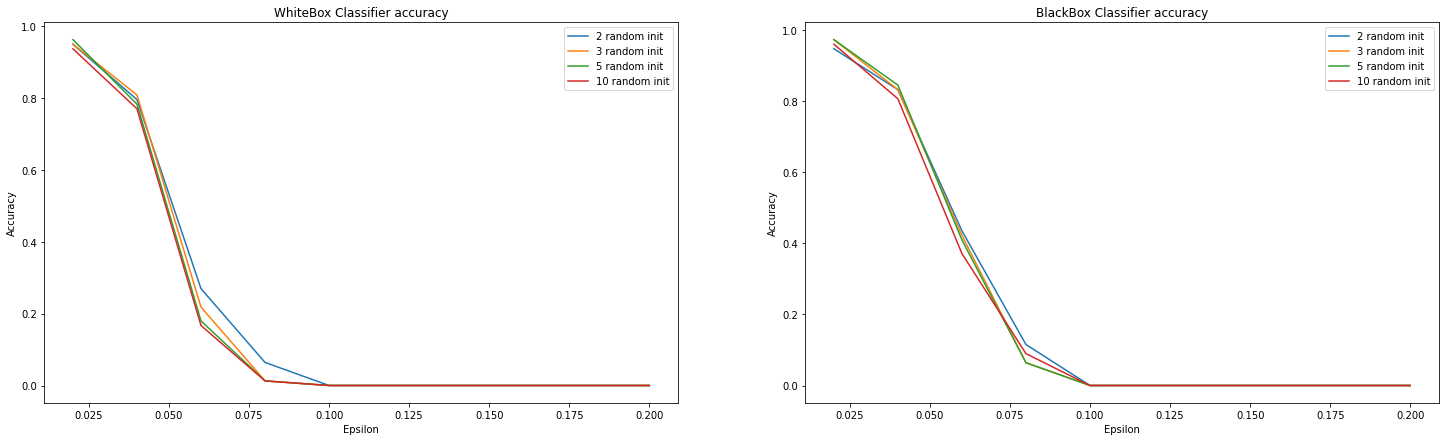

In [ ]:
#----------------WhiteBox----------------------
f = plt.figure(figsize=(25, 7))
f.add_subplot(1, 2, 1)
plt.plot(epsilon_step,net_acc_WB[0:10])
plt.plot(epsilon_step,net_acc_WB[10:20])
plt.plot(epsilon_step,net_acc_WB[20:30])
plt.plot(epsilon_step,net_acc_WB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox Classifier accuracy")
plt.legend(["2 random init", "3 random init","5 random init","10 random init"], loc=0, frameon=True)

#----------------BlackBox----------------------
f.add_subplot(1, 2, 2)
plt.plot(epsilon_step,net_acc_BB[0:10])
plt.plot(epsilon_step,net_acc_BB[10:20])
plt.plot(epsilon_step,net_acc_BB[20:30])
plt.plot(epsilon_step,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox Classifier accuracy")
plt.legend(["2 random init", "3 random init","5 random init","10 random init"], loc=0, frameon=True)

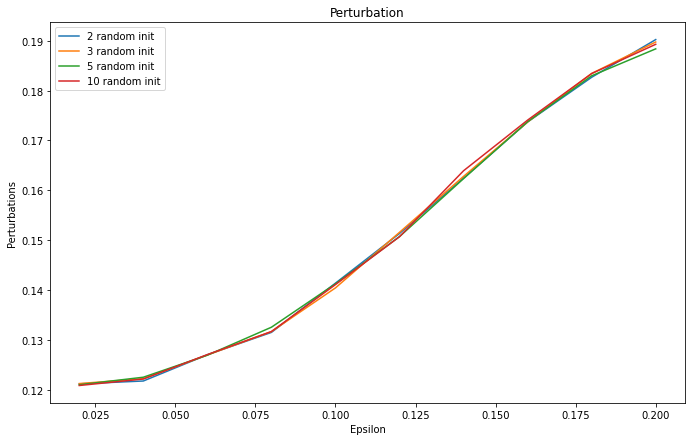

In [ ]:
#----------------PERTURBATIONS----------------------
f = plt.figure(figsize=(25, 7))
f.add_subplot(1, 2, 1)
plt.plot(epsilon_step,perturbs[0:10])
plt.plot(epsilon_step,perturbs[10:20])
plt.plot(epsilon_step,perturbs[20:30])
plt.plot(epsilon_step,perturbs[30:40])
plt.ylabel("Perturbations")
plt.xlabel("Epsilon")
plt.title("Perturbation")
plt.legend(["2 random init", "3 random init","5 random init","10 random init"], loc=0, frameon=True)


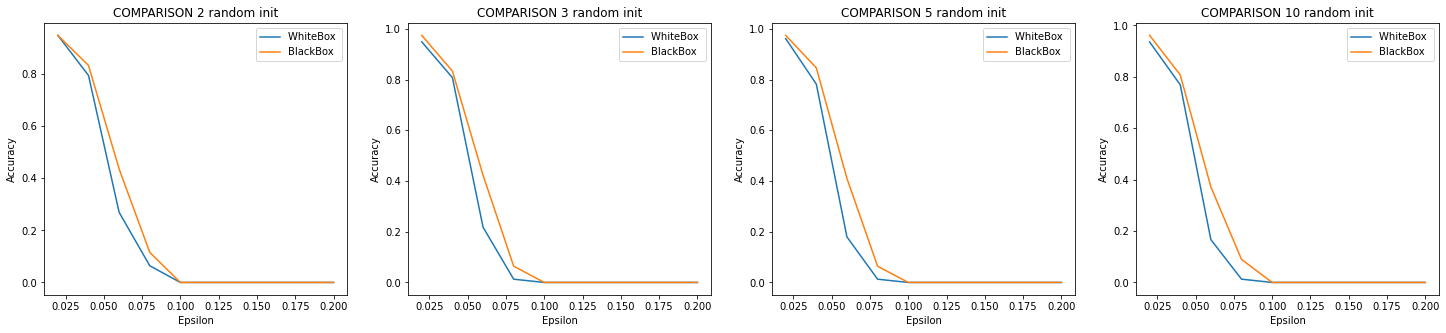

In [ ]:
#-----------COMPARISON------------
f = plt.figure(figsize=(25, 5))
f.add_subplot(1, 4, 1)
plt.plot(epsilon_step,net_acc_WB[0:10])
plt.plot(epsilon_step,net_acc_BB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 2 random init")
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)
f.add_subplot(1, 4, 2)
plt.plot(epsilon_step,net_acc_WB[10:20])
plt.plot(epsilon_step,net_acc_BB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 3 random init")
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)
f.add_subplot(1, 4, 3)
plt.plot(epsilon_step,net_acc_WB[20:30])
plt.plot(epsilon_step,net_acc_BB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 5 random init")
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)
f.add_subplot(1, 4, 4)
plt.plot(epsilon_step,net_acc_WB[30:40])
plt.plot(epsilon_step,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 10 random init")
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)

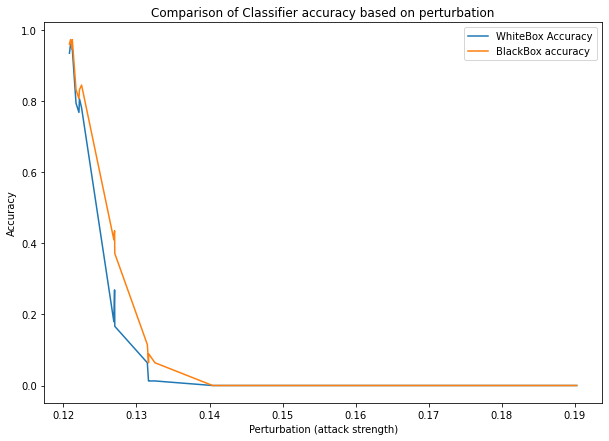

In [ ]:
perturbations, indices = order_list_take_indices(perturbs)
net_acc_WB2 = order_on_indices(indices, net_acc_WB)
net_acc_BB2 = order_on_indices(indices, net_acc_BB)
#--------- Comparison on perturbations -----------
f = plt.figure(figsize=(10, 7))
plt.plot(perturbations, net_acc_WB2)
plt.plot(perturbations, net_acc_BB2)
plt.ylabel("Accuracy")
plt.xlabel("Perturbation (attack strength)")
plt.title("Comparison of Classifier accuracy based on perturbation")
plt.legend(["WhiteBox Accuracy", "BlackBox accuracy "], loc=0, frameon=True)

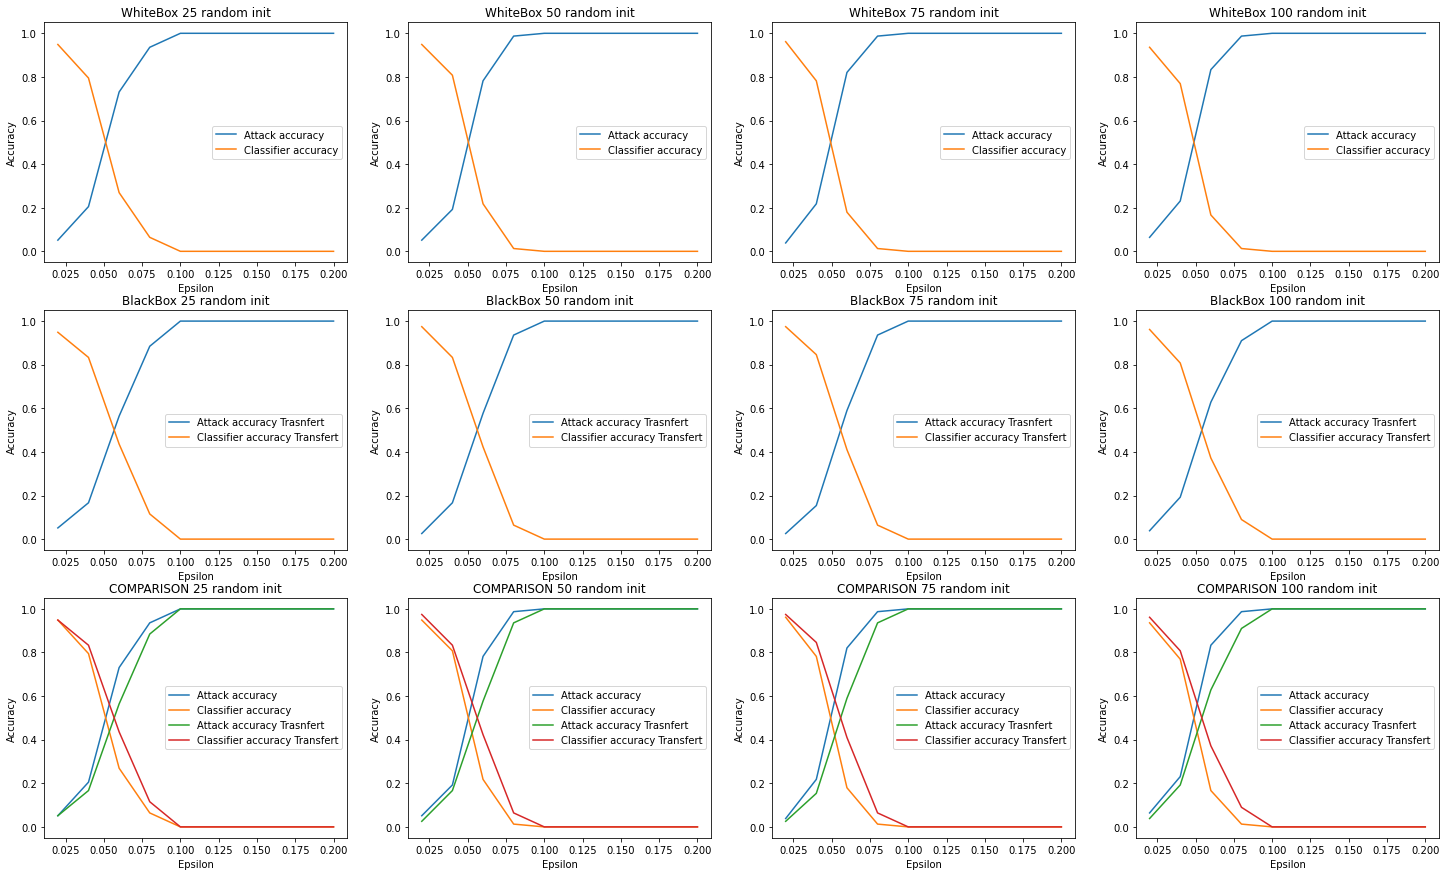

In [ ]:
#----------------WhiteBox----------------------
f = plt.figure(figsize=(25, 15))
f.add_subplot(3, 4, 1)
plt.plot(epsilon_step,atk_acc_WB[0:10])
plt.plot(epsilon_step,net_acc_WB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 25 random init")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)
f.add_subplot(3, 4, 2)
plt.plot(epsilon_step,atk_acc_WB[10:20])
plt.plot(epsilon_step,net_acc_WB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 50 random init")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)
f.add_subplot(3, 4, 3)
plt.plot(epsilon_step,atk_acc_WB[20:30])
plt.plot(epsilon_step,net_acc_WB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 75 random init")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)
f.add_subplot(3, 4, 4)
plt.plot(epsilon_step,atk_acc_WB[30:40])
plt.plot(epsilon_step,net_acc_WB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 100 random init")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)

#----------------BlackBox----------------------
f.add_subplot(3, 4, 5)
plt.plot(epsilon_step,atk_acc_BB[0:10])
plt.plot(epsilon_step,net_acc_BB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 25 random init")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 6)
plt.plot(epsilon_step,atk_acc_BB[10:20])
plt.plot(epsilon_step,net_acc_BB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 50 random init")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 7)
plt.plot(epsilon_step,atk_acc_BB[20:30])
plt.plot(epsilon_step,net_acc_BB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 75 random init")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 8)
plt.plot(epsilon_step,atk_acc_BB[30:40])
plt.plot(epsilon_step,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 100 random init")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)

#-----------COMPARISON------------
f.add_subplot(3, 4, 9)
plt.plot(epsilon_step,atk_acc_WB[0:10])
plt.plot(epsilon_step,net_acc_WB[0:10])
plt.plot(epsilon_step,atk_acc_BB[0:10])
plt.plot(epsilon_step,net_acc_BB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 25 random init")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 10)
plt.plot(epsilon_step,atk_acc_WB[10:20])
plt.plot(epsilon_step,net_acc_WB[10:20])
plt.plot(epsilon_step,atk_acc_BB[10:20])
plt.plot(epsilon_step,net_acc_BB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 50 random init")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 11)
plt.plot(epsilon_step,atk_acc_WB[20:30])
plt.plot(epsilon_step,net_acc_WB[20:30])
plt.plot(epsilon_step,atk_acc_BB[20:30])
plt.plot(epsilon_step,net_acc_BB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 75 random init")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 12)
plt.plot(epsilon_step,atk_acc_WB[30:40])
plt.plot(epsilon_step,net_acc_WB[30:40])
plt.plot(epsilon_step,atk_acc_BB[30:40])
plt.plot(epsilon_step,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 100 random init")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)

##DEEPFOOL

In [ ]:
whiteBox = tf.keras.models.load_model("models/whiteBox.h5")
# Create a logit model from whiteBox
WB_logit_model = Model(inputs=whiteBox.input, outputs=whiteBox.layers[-2].output)

# Create a ART Keras classifier for the TensorFlow Keras model.
classifier_deepfool = KerasClassifier(model=WB_logit_model, clip_values=(0, 1))

In [ ]:
epsilon = [0.00001,0.001,0.005,0.01,0.015,0.02,0.025,0.03,0.05,0.1]
max_iter = [2,3,5,10]
target_class_df = 1
attack_classes_df = 2
atk_acc_WB = []
net_acc_WB = []
atk_acc_BB = []
net_acc_BB = []
perturbs = []

dey_test = de_one_hot(Y_test_cat)
targeted_labels_df = target_class_df*np.ones(y_test.size)
one_hot_targeted_labels_df = tf.keras.utils.to_categorical(targeted_labels_df, num_classes=attack_classes_df)


for i in max_iter:
  for j in epsilon:
    print("\n-------------------------------------------------------\nepsilon: " + str(j) + "       iterations: " + str(i) )
    attack_df = DeepFool(classifier=classifier_deepfool, epsilon=j, max_iter=i,verbose = False)
    test_audios_adv_df = attack_df.generate(X_test, one_hot_targeted_labels_df)

    perturbation = np.mean(np.abs((test_audios_adv_df - X_test)))
    print('Average perturbation: {:4.4f}'.format(perturbation))
    print("\n\t\tWhiteBox")
    perturbs.append(perturbation)

    loss_test, accuracy_test = whiteBox.evaluate(test_audios_adv_df, Y_test_cat, verbose=False)
    net_acc_WB.append(accuracy_test)
    print('Accuracy on adversarial test data:',accuracy_test)

    targeted_attack_loss, targeted_attack_accuracy = whiteBox.evaluate(test_audios_adv_df, one_hot_targeted_labels_df, verbose = False)
    atk_acc_WB.append(targeted_attack_accuracy)
    print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')

    print("\t\tBlackBox")
    loss_test, accuracy_test = blackBox.evaluate(test_audios_adv_df, Y_test_cat, verbose=False)
    net_acc_BB.append(accuracy_test)
    print('Accuracy on adversarial test data:',accuracy_test)
    
    targeted_attack_loss, targeted_attack_accuracy = blackBox.evaluate(test_audios_adv_df, one_hot_targeted_labels_df, verbose=False)
    atk_acc_BB.append(targeted_attack_accuracy)
    print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')


-------------------------------------------------------
epsilon: 1e-05       iterations: 2
Average perturbation: 0.0581

		WhiteBox
Accuracy on adversarial test data: 0.35897437
Targeted attack accuracy: 0.64 

		BlackBox
Accuracy on adversarial test data: 0.6666667
Targeted attack accuracy: 0.33 


-------------------------------------------------------
epsilon: 0.001       iterations: 2
Average perturbation: 0.0582

		WhiteBox
Accuracy on adversarial test data: 0.34615386
Targeted attack accuracy: 0.65 

		BlackBox
Accuracy on adversarial test data: 0.6666667
Targeted attack accuracy: 0.33 


-------------------------------------------------------
epsilon: 0.005       iterations: 2
Average perturbation: 0.0584

		WhiteBox
Accuracy on adversarial test data: 0.26923078
Targeted attack accuracy: 0.73 

		BlackBox
Accuracy on adversarial test data: 0.65384614
Targeted attack accuracy: 0.35 


-------------------------------------------------------
epsilon: 0.01       iterations: 2
Avera

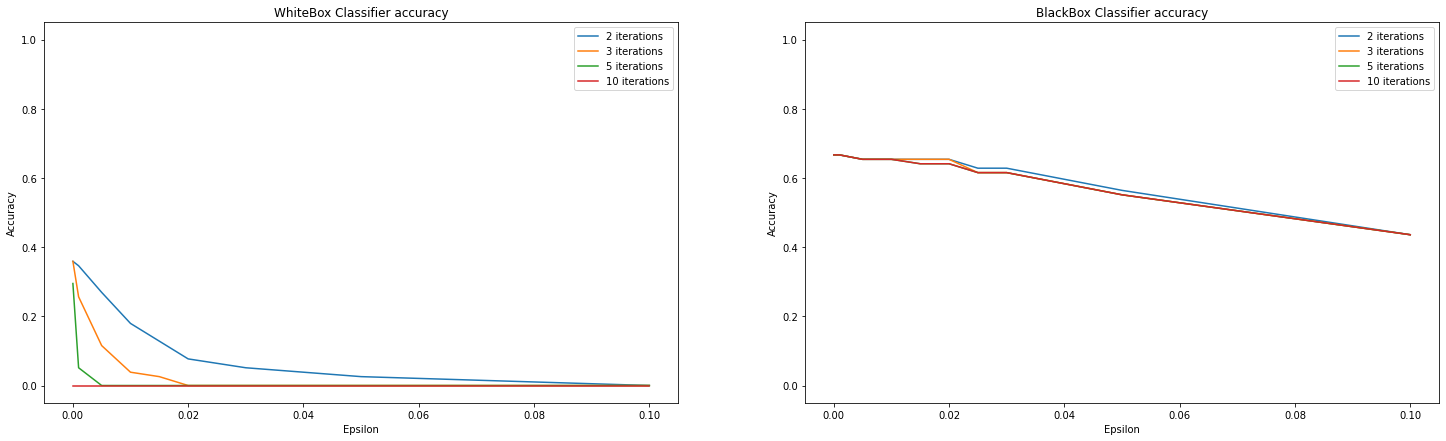

In [ ]:
#----------------WhiteBox----------------------
f = plt.figure(figsize=(25, 7))
f.add_subplot(1, 2, 1)
plt.plot(epsilon,net_acc_WB[0:10])
plt.plot(epsilon,net_acc_WB[10:20])
plt.plot(epsilon,net_acc_WB[20:30])
plt.plot(epsilon,net_acc_WB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.ylim(-0.05,1.05)
plt.title("WhiteBox Classifier accuracy")
plt.legend(["2 iterations", "3 iterations","5 iterations","10 iterations"], loc=0, frameon=True)

#----------------BlackBox----------------------
f.add_subplot(1, 2, 2)
plt.plot(epsilon,net_acc_BB[0:10])
plt.plot(epsilon,net_acc_BB[10:20])
plt.plot(epsilon,net_acc_BB[20:30])
plt.plot(epsilon,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.ylim(-0.05,1.05)
plt.title("BlackBox Classifier accuracy")
plt.legend(["2 iterations", "3 iterations","5 iterations","10 iterations"], loc=0, frameon=True)

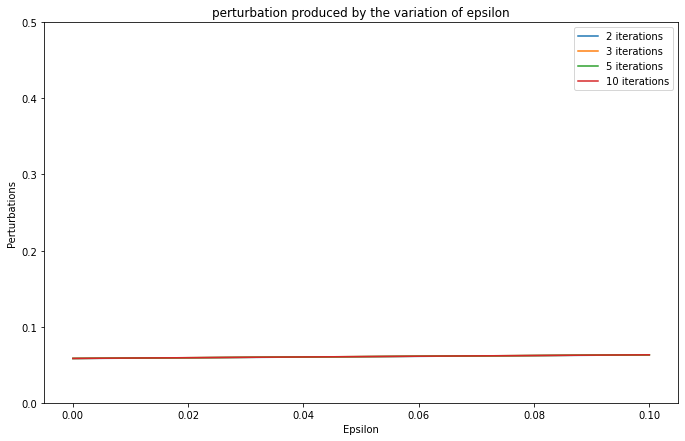

In [ ]:
#----------------PERTURBATIONS----------------------
f = plt.figure(figsize=(25, 7))
f.add_subplot(1, 2, 1)
plt.plot(epsilon,perturbs[0:10])
plt.plot(epsilon,perturbs[10:20])
plt.plot(epsilon,perturbs[20:30])
plt.plot(epsilon,perturbs[30:40])
plt.ylabel("Perturbations")
plt.xlabel("Epsilon")
plt.ylim((0,0.5))
plt.title("perturbation produced by the variation of epsilon")
plt.legend(["2 iterations", "3 iterations","5 iterations","10 iterations"], loc=0, frameon=True)

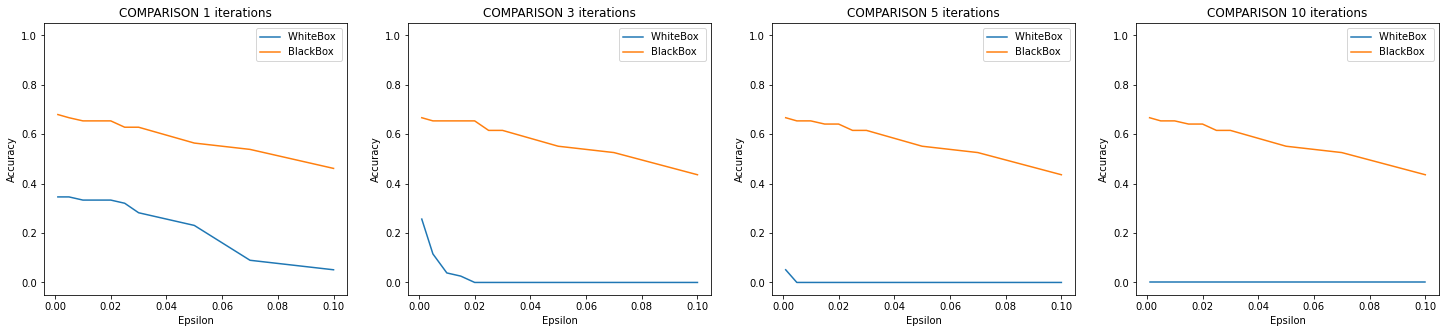

In [ ]:
#-----------COMPARISON------------
f = plt.figure(figsize=(25, 5))
f.add_subplot(1, 4, 1)
plt.plot(epsilon,net_acc_WB[0:10])
plt.plot(epsilon,net_acc_BB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 1 iterations")
plt.ylim(-0.05,1.05)
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)
f.add_subplot(1, 4, 2)
plt.plot(epsilon,net_acc_WB[10:20])
plt.plot(epsilon,net_acc_BB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 3 iterations")
plt.ylim(-0.05,1.05)
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)
f.add_subplot(1, 4, 3)
plt.plot(epsilon,net_acc_WB[20:30])
plt.plot(epsilon,net_acc_BB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 5 iterations")
plt.ylim(-0.05,1.05)
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)
f.add_subplot(1, 4, 4)
plt.plot(epsilon,net_acc_WB[30:40])
plt.plot(epsilon,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 10 iterations")
plt.ylim(-0.05,1.05)
plt.legend(["WhiteBox ", "BlackBox"], loc=0, frameon=True)

In [ ]:
perturbations, indices = order_list_take_indices(perturbs)
net_acc_WB2 = order_on_indices(indices, net_acc_WB)
net_acc_BB2 = order_on_indices(indices, net_acc_BB)
#--------- Comparison on perturbations -----------
f = plt.figure(figsize=(10, 7))
plt.plot(perturbations, net_acc_WB2)
plt.plot(perturbations, net_acc_BB2)
plt.ylabel("Accuracy")
plt.xlabel("Perturbation (attack strength)")
plt.title("Comparison of Classifier accuracy based on perturbation")
plt.ylim(-0.05,1.05)
plt.legend(["WhiteBox Accuracy", "BlackBox accuracy "], loc=0, frameon=True)

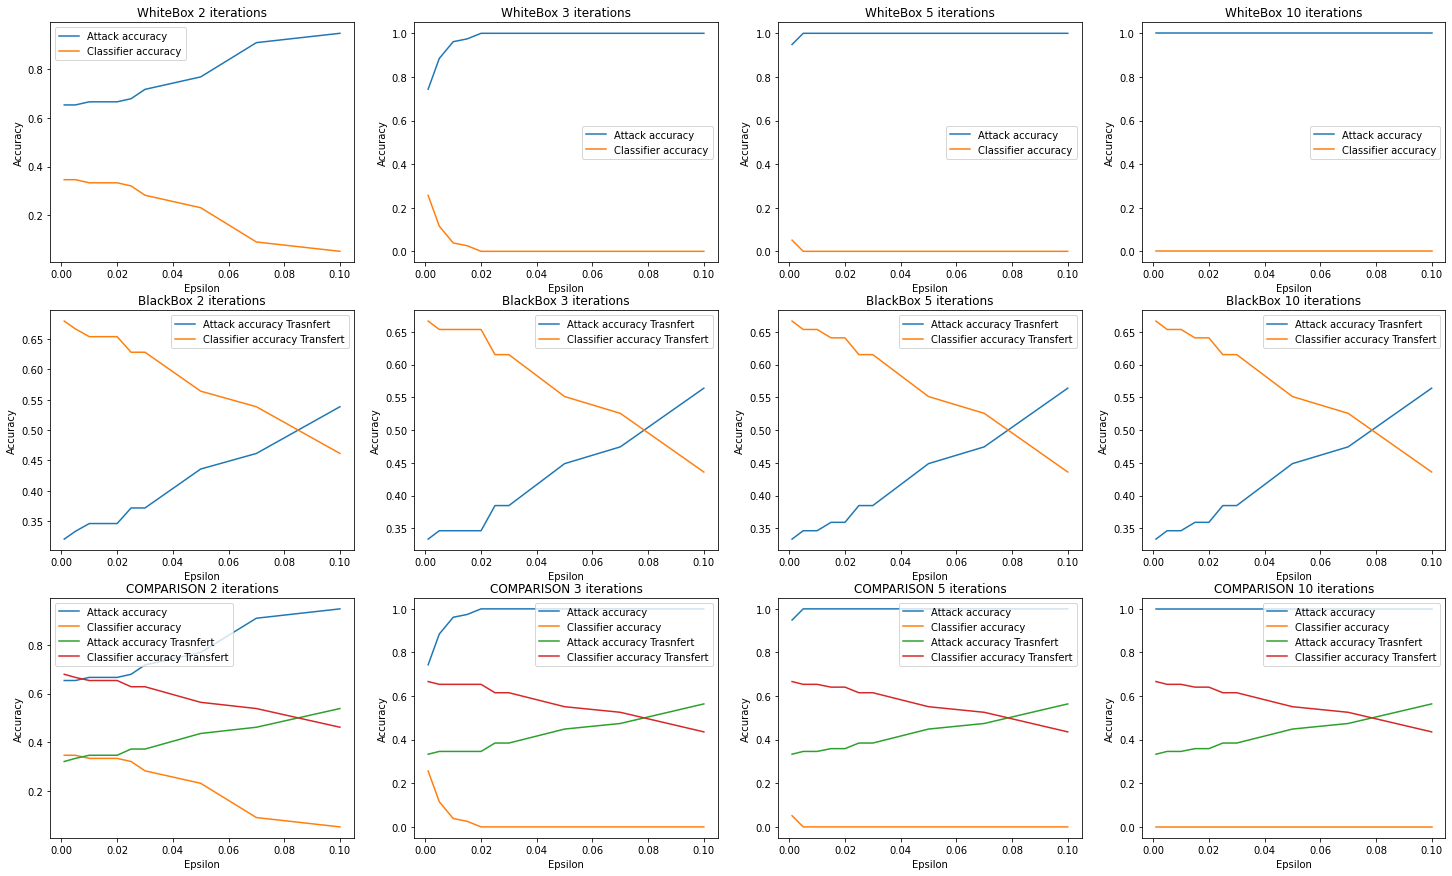

In [ ]:
#----------------WhiteBox----------------------
f = plt.figure(figsize=(25, 15))
f.add_subplot(3, 4, 1)
plt.plot(epsilon,atk_acc_WB[0:10])
plt.plot(epsilon,net_acc_WB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 2 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)
f.add_subplot(3, 4, 2)
plt.plot(epsilon,atk_acc_WB[10:20])
plt.plot(epsilon,net_acc_WB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 3 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)
f.add_subplot(3, 4, 3)
plt.plot(epsilon,atk_acc_WB[20:30])
plt.plot(epsilon,net_acc_WB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 5 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)
f.add_subplot(3, 4, 4)
plt.plot(epsilon,atk_acc_WB[30:40])
plt.plot(epsilon,net_acc_WB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("WhiteBox 10 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy"], loc=0, frameon=True)

#----------------BlackBox----------------------
f.add_subplot(3, 4, 5)
plt.plot(epsilon,atk_acc_BB[0:10])
plt.plot(epsilon,net_acc_BB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 2 iterations")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 6)
plt.plot(epsilon,atk_acc_BB[10:20])
plt.plot(epsilon,net_acc_BB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 3 iterations")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 7)
plt.plot(epsilon,atk_acc_BB[20:30])
plt.plot(epsilon,net_acc_BB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 5 iterations")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 8)
plt.plot(epsilon,atk_acc_BB[30:40])
plt.plot(epsilon,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("BlackBox 10 iterations")
plt.legend(["Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)

#-----------COMPARISON------------
f.add_subplot(3, 4, 9)
plt.plot(epsilon,atk_acc_WB[0:10])
plt.plot(epsilon,net_acc_WB[0:10])
plt.plot(epsilon,atk_acc_BB[0:10])
plt.plot(epsilon,net_acc_BB[0:10])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 2 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 10)
plt.plot(epsilon,atk_acc_WB[10:20])
plt.plot(epsilon,net_acc_WB[10:20])
plt.plot(epsilon,atk_acc_BB[10:20])
plt.plot(epsilon,net_acc_BB[10:20])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 3 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 11)
plt.plot(epsilon,atk_acc_WB[20:30])
plt.plot(epsilon,net_acc_WB[20:30])
plt.plot(epsilon,atk_acc_BB[20:30])
plt.plot(epsilon,net_acc_BB[20:30])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 5 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)
f.add_subplot(3, 4, 12)
plt.plot(epsilon,atk_acc_WB[30:40])
plt.plot(epsilon,net_acc_WB[30:40])
plt.plot(epsilon,atk_acc_BB[30:40])
plt.plot(epsilon,net_acc_BB[30:40])
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("COMPARISON 10 iterations")
plt.legend(["Attack accuracy", "Classifier accuracy", "Attack accuracy Trasnfert", "Classifier accuracy Transfert"], loc=0, frameon=True)

## CARLINI WAGNER


In [ ]:
whiteBox = tf.keras.models.load_model("models/whiteBox.h5")
# Create a logit model from whiteBox
WB_logit_model = Model(inputs=whiteBox.input, outputs=whiteBox.layers[-2].output)

# Create a ART Keras classifier for the TensorFlow Keras model.
classifier_cw = KerasClassifier(model=WB_logit_model, clip_values=(0, 1))

In [ ]:
binary_search_steps = 1
confidence = 0.9
max_iterations = 20
learning_rate = 0.0001 
initial_const = 1
target_class_cw = 1
attack_classes_cw = 2

dey_test = de_one_hot(Y_test_cat)
targeted_labels_cw = target_class_cw*np.ones(y_test.shape[0])
one_hot_targeted_labels_cw = tf.keras.utils.to_categorical(targeted_labels_cw, num_classes = attack_classes_cw)


attack_cw = CarliniL2Method(classifier=classifier_cw, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iterations, learning_rate=learning_rate, initial_const=initial_const, targeted=True)
test_audios_adv_cw = attack_cw.generate(X_test, one_hot_targeted_labels_cw)
print("Parameters\nbinary_search_steps: ",binary_search_steps,"\nconfidence: ",confidence, "\nmax_iterations: ", max_iterations,"\nlearning_rate: ",learning_rate,"\ninitial_const: ", initial_const)
print("-------------------------------------")
perturbation = np.mean(np.abs((test_audios_adv_cw - X_test)))
print('Average perturbation:',perturbation)
print("\n\t\tWhiteBox")

loss_test, accuracy_test = whiteBox.evaluate(test_audios_adv_cw, Y_test_cat, verbose=0)
print('Accuracy on adversarial test data:',accuracy_test)

targeted_attack_loss, targeted_attack_accuracy = whiteBox.evaluate(test_audios_adv_cw, one_hot_targeted_labels_cw, verbose = 0)
print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')

print("\t\tBlackBox")
loss_test, accuracy_test = blackBox.evaluate(test_audios_adv_cw, Y_test_cat, verbose=False)
print('Accuracy on adversarial test data:',accuracy_test)


targeted_attack_loss, targeted_attack_accuracy = blackBox.evaluate(test_audios_adv_cw, one_hot_targeted_labels_cw, verbose=False)
print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy),'\n')

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

Parameters
binary_search_steps:  4 
confidence:  0.5 
max_iterations:  2 
learning_rate:  0.0001 
initial_const:  1
-------------------------------------
Average perturbation: 0.00014722453

		WhiteBox
Accuracy on adversarial test data: 0.96153843
Targeted attack accuracy: 0.04 

		BlackBox
Accuracy on adversarial test data: 0.96153843
Targeted attack accuracy: 0.04 



In [ ]:
#Vectors are hand-made because it's not possible to perform all tests due to the time limitations of Colab, we saved the results and built the vectors

perturbations = [0.0006308177,0.01324295,0.038872402,0.046498127,0.052337162,0.057099894,0.05932171] 
net_acc_WB = [0.96153843,0.7307692,0.2948718,0.16666667,0.08974359,0.025641026,0.0]
net_acc_BB = [0.974359,0.78205127,0.4871795,0.3846154,0.3846154,0.3846154,0.3846154]
m_i = [3,4,5,6,7,10,20]

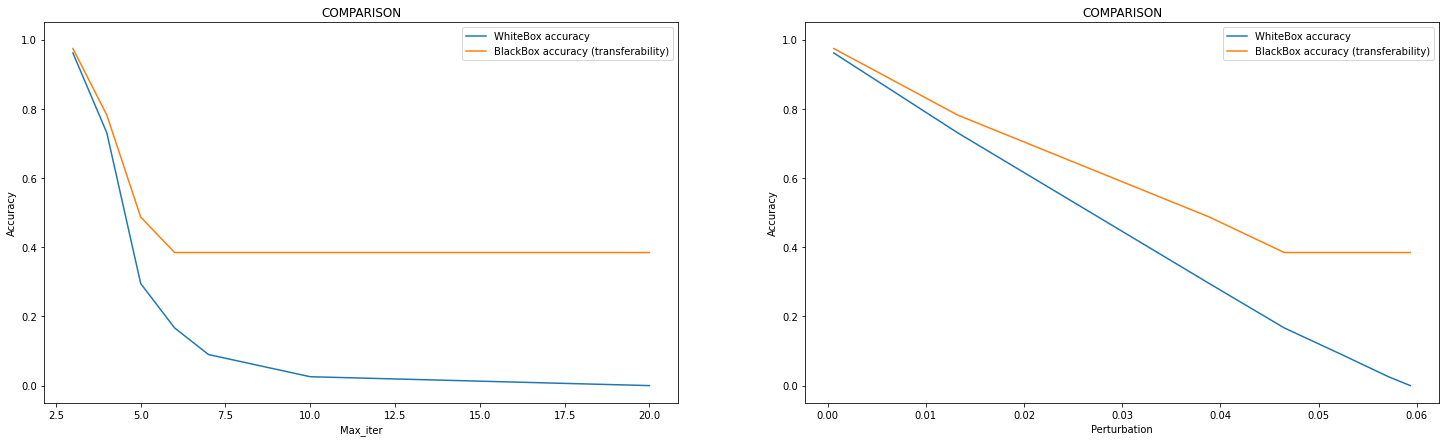

In [ ]:
f = plt.figure(figsize=(25, 7))
f.add_subplot(1, 2, 1)
plt.plot(m_i,net_acc_WB)
plt.plot(m_i,net_acc_BB)
plt.ylabel("Accuracy")
plt.xlabel("Max_iter")
plt.title("COMPARISON")
plt.ylim(-0.05,1.05)
plt.legend(["WhiteBox accuracy", "BlackBox accuracy (transferability)"], loc=0, frameon=True)
f.add_subplot(1, 2, 2)
plt.plot(perturbations,net_acc_WB)
plt.plot(perturbations,net_acc_BB)
plt.ylabel("Accuracy")
plt.xlabel("Perturbation")
plt.title("COMPARISON")
plt.ylim(-0.05,1.05)
plt.legend(["WhiteBox accuracy", "BlackBox accuracy (transferability)"], loc=0, frameon=True)

#DEFENSE

##UTILS

In [ ]:
X_train_det = SpeakerId.predict(X_def)
X_test_det = SpeakerId.predict(X_def_adv)
y_train_det = to_categorical(y_def, 2)
y_test_det = to_categorical(y_def_adv, 2)
for i in range(len(X_train_det)):
  X_train_det[i] = (X_train_det[i] - X_train_det[i][np.argmin(X_train_det[i])]) /  (X_train_det[i][np.argmax(X_train_det[i])] - X_train_det[i][np.argmin(X_train_det[i])])
for i in range(len(X_test)):
  X_test_det[i] = (X_test_det[i] - X_test_det[i][np.argmin(X_test_det[i])]) /  (X_test_det[i][np.argmax(X_test_det[i])] - X_test_det[i][np.argmin(X_test_det[i])])

In [ ]:
whiteBox = tf.keras.models.load_model("models/whiteBox.h5")
# Create a ART Keras classifier for the TensorFlow Keras model.
classifier= KerasClassifier(model=whiteBox, clip_values=(0, 1), use_logits=False)

# Create a logit model from whiteBox
WB_logit_model = Model(inputs=whiteBox.input, outputs=whiteBox.layers[-2].output)
# Create a ART Keras classifier for the TensorFlow Keras model.
classifier_logits = KerasClassifier(model=WB_logit_model, clip_values=(0, 1))

target_class = 1
attack_classes = 2

## ***FGSM*** DETECTOR 

In [ ]:
epsilons = [0,0.01,0.02,0.03,0.04,0.05,0.07,0.08,0.09,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.29,0.3]
num_epsilons = len(epsilons)

tot_audios_adv = []
tot_y_adv = []

tot_test_audios_adv = []
tot_test_y_adv = []

rest_of_set=X_train_det
rest_of_y=y_train_det

rest_of_test_set = X_test_det
rest_of_test_y = y_test_det

c=1

for epsilon in tqdm(epsilons):
  
  if c==num_epsilons:
    subset=rest_of_set
    test_subset = rest_of_test_set
    y_subset = rest_of_y
    y_test_det_subset = rest_of_test_y
  else:
    rest_of_set, subset, rest_of_y, y_subset = train_test_split(rest_of_set, rest_of_y, test_size=int(len(X_train_det)/num_epsilons), random_state=42)
    rest_of_test_set, test_subset, rest_of_test_y, y_test_det_subset = train_test_split(rest_of_test_set, rest_of_test_y, test_size=int(len(X_test_det)/num_epsilons), random_state=42)
  
 
  attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=True)
  
  targeted_labels = target_class*np.ones(y_subset.size)
  targeted_test_labels = target_class*np.ones(y_test_det_subset.size)

  one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=attack_classes)  
  one_hot_targeted_test_labels = tf.keras.utils.to_categorical(targeted_test_labels, num_classes=attack_classes)  

  audios_adv = attack.generate(subset, one_hot_targeted_labels)
  audios_test_adv = attack.generate(test_subset, one_hot_targeted_test_labels)
  

  if c==1:
    tot_audios_adv = np.concatenate((X_train_det, audios_adv), axis=0)
    tot_test_audios_adv = np.concatenate((X_test_det, audios_test_adv), axis=0)
  else:
    tot_audios_adv = np.concatenate((tot_audios_adv, audios_adv), axis=0)
    tot_test_audios_adv = np.concatenate((tot_test_audios_adv, audios_test_adv), axis=0)
  c=c+1

100%|██████████| 21/21 [00:00<00:00, 51.76it/s]


In [ ]:
num_y = X_train_det.shape[0]
tot_y_adv = np.concatenate((np.array([[1,0]]*num_y), np.array([[0,1]]*num_y)), axis=0)

In [ ]:
fileH5 = 'Datasets/FGSM_detector_ADV_test.h5'
file = h5py.File(fileH5, "w")
dataset = file.create_dataset("audio", data=tot_test_audios_adv[78:])
file.close()

In [ ]:
file = h5py.File('Datasets/FGSM_detector_train.h5', "w")
dataset = file.create_dataset("feature", data=tot_audios_adv)
dataset = file.create_dataset("labels", data=tot_y_adv)
file.close()

In [ ]:
f = h5py.File('Datasets/FGSM_detector_train.h5', 'r')

X_train_det_fgsm = f['feature'][...]
y_train_det_fgsm = f['labels'][...]
f.close()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

detector_fgsm = RandomForestClassifier(n_estimators=150, random_state=42)
detector_fgsm.fit(X_train_det_fgsm, y_train_det_fgsm)

RandomForestClassifier(n_estimators=150, random_state=42)

In [ ]:
pickle.dump(detector_fgsm, open("models/detector_fgsm.h5", "wb"))

In [ ]:
detector_fgsm = pickle.load(open("models/detector_fgsm.h5", "rb"))

In [ ]:
f = h5py.File('Datasets/FGSM_detector_ADV_test.h5', 'r')

X_adv_fgsm = f['audio'][...]
f.close()

In [ ]:
flag_adv = np.sum(np.argmax(detector_fgsm.predict(X_adv_fgsm), axis=1) == 1)

print("Adversarial test data:")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(len(X_adv_fgsm) - flag_adv))

Adversarial test data:
Flagged: 73
Not flagged: 5


In [ ]:
flag_original = np.sum(np.argmax(detector_fgsm.predict(X_test_det), axis=1) == 1)

print("Original test data:")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(len(X_test_det) - flag_original))

Original test data:
Flagged: 0
Not flagged: 78


###CERTIFIED DEFENCE

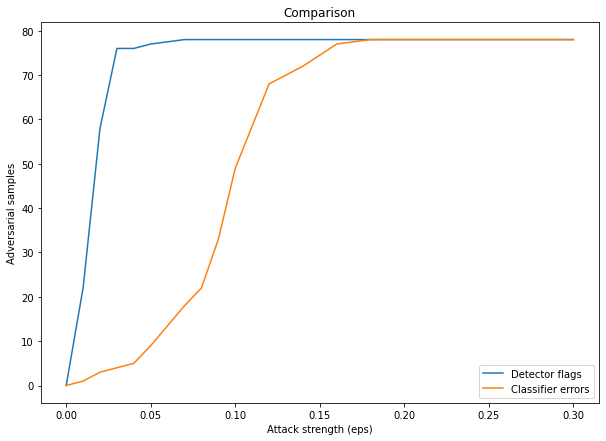

In [ ]:
eps_range = [0,0.01,0.02,0.03,0.04,0.05,0.07,0.08,0.09,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.29,0.3]

nb_flag_adv = []
nb_missclass = []


for eps in eps_range:
    attack = FastGradientMethod(estimator=classifier, eps=eps)
    x_test_adv = attack.generate(X_test_det)
    nb_flag_adv += [np.sum(np.argmax(detector_fgsm.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test_det, axis=1))]
    
eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [0] + nb_missclass


f = plt.figure(figsize=(10, 7))
plt.plot(np.array(eps_range), np.array(nb_flag_adv))
plt.plot(np.array(eps_range), np.array(nb_missclass))

plt.legend(["Detector flags", "Classifier errors"], loc=0, frameon=True)

plt.xlabel('Attack strength (eps)')
plt.ylabel('Adversarial samples')
plt.title("Comparison")
plt.show()

## ***BIM*** DETECTOR 

In [ ]:
epsilon = 1

num_epsilon_steps = 10
epsilon_steps = [0.001,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]

num_max_iter = 4
max_iter = [2,3,5,10]

tot_audios_adv = []
tot_y_adv = []

tot_test_audios_adv = []
tot_test_y_adv = []

rest_of_set=X_train_det
rest_of_y=y_train_det

rest_of_test_set = X_test_det
rest_of_test_y = y_test_det
mi=1
es=1


for iter in max_iter:
  es=1
  for epsilon_step in epsilon_steps:
    if mi==num_max_iter and es==num_epsilon_steps:
      subset=rest_of_set
      test_subset = rest_of_test_set
      y_subset = rest_of_y
      y_test_det_subset = rest_of_test_y
    else:
      rest_of_set, subset, rest_of_y, y_subset = train_test_split(rest_of_set, rest_of_y, test_size=int(len(X_train_det)/(num_max_iter*num_epsilon_steps)), random_state=42)
      rest_of_test_set, test_subset, rest_of_test_y, y_test_det_subset = train_test_split(rest_of_test_set, rest_of_test_y, test_size=int(len(X_test_det)/(num_max_iter*num_epsilon_steps)), random_state=42)
    
  
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=iter, targeted=True, verbose=False)

    targeted_labels = target_class*np.ones(y_subset.size)
    targeted_test_labels = target_class*np.ones(y_test_det_subset.size)
    one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=attack_classes) 
    one_hot_targeted_test_labels = tf.keras.utils.to_categorical(targeted_test_labels, num_classes=attack_classes)   
    audios_adv = attack.generate(subset, one_hot_targeted_labels)
    audios_test_adv = attack.generate(test_subset, one_hot_targeted_test_labels)


    if mi==1 and es==1:
      tot_audios_adv = np.concatenate((X_train_det, audios_adv), axis=0)
      tot_test_audios_adv = np.concatenate((X_test_det, audios_test_adv), axis=0)
    else:
      tot_audios_adv = np.concatenate((tot_audios_adv, audios_adv), axis=0)
      tot_test_audios_adv = np.concatenate((tot_test_audios_adv, audios_test_adv), axis=0)
    es=es+1
  mi=mi+1


In [ ]:
num_y = X_train_det.shape[0]
tot_y_adv = np.concatenate((np.array([[1,0]]*num_y), np.array([[0,1]]*num_y)), axis=0)

In [ ]:
fileH5 = 'Datasets/BIM_detector_ADV_test.h5'
file = h5py.File(fileH5, "w")
dataset = file.create_dataset("audio", data=tot_test_audios_adv[78:])
file.close()

In [ ]:
file = h5py.File('Datasets/BIM_detector_train.h5', "w")
dataset = file.create_dataset("feature", data=tot_audios_adv)
dataset = file.create_dataset("labels", data=tot_y_adv)
file.close()

In [ ]:
f = h5py.File('Datasets/BIM_detector_train.h5', 'r')

X_train_det_bim = f['feature'][...]
y_train_det_bim = f['labels'][...]
f.close()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

detector_bim = RandomForestClassifier(n_estimators=150, random_state=42)
detector_bim.fit(X_train_det_bim, y_train_det_bim)

RandomForestClassifier(n_estimators=150, random_state=42)

In [ ]:
pickle.dump(detector_bim, open("models/detector_bim.h5", "wb"))

In [ ]:
detector_bim = pickle.load(open("models/detector_bim.h5", "rb"))

In [ ]:
f = h5py.File('Datasets/BIM_detector_ADV_test.h5', 'r')

X_adv_bim = f['audio'][...]
f.close()

In [ ]:
flag_adv = np.sum(np.argmax(detector_bim.predict(X_adv_bim), axis=1) == 1)

print("Adversarial test data:")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(len(X_adv_bim) - flag_adv))

Adversarial test data:
Flagged: 74
Not flagged: 4


In [ ]:
flag_original = np.sum(np.argmax(detector_bim.predict(X_test_det), axis=1) == 1)

print("Original test data:")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(len(X_test_det) - flag_original))

Original test data:
Flagged: 0
Not flagged: 78


###CERTIFIED DEFENCE

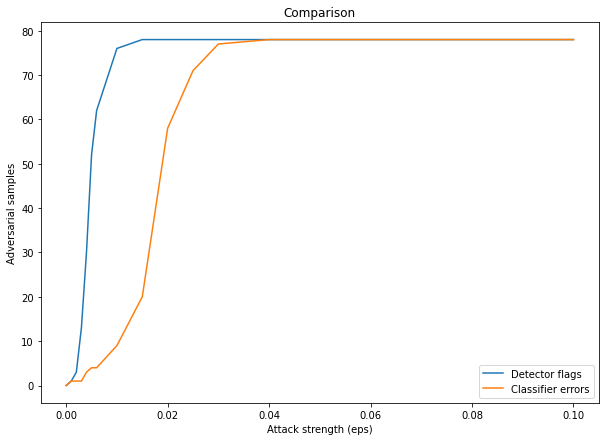

In [ ]:
epsilon = 1
iter = 5
eps_step_range = [0.001,0.002,0.003,0.004,0.005,0.006,0.01,0.015,0.02,0.025,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]

nb_flag_adv = []
nb_missclass = []


for eps_step in eps_step_range:
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=eps_step, max_iter=iter, verbose=False) 
    x_test_adv = attack.generate(X_test_det)
    nb_flag_adv += [np.sum(np.argmax(detector_bim.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test_det, axis=1))]
    
eps_step_range = [0] + eps_step_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [0] + nb_missclass


f = plt.figure(figsize=(10, 7))
plt.plot(np.array(eps_step_range), np.array(nb_flag_adv))
plt.plot(np.array(eps_step_range), np.array(nb_missclass))

plt.legend(["Detector flags", "Classifier errors"], loc=0, frameon=True)

plt.xlabel('Attack strength (eps)')
plt.ylabel('Adversarial samples')
plt.title("Comparison")
plt.show()

## ***PGD*** DETECTOR 

In [ ]:
epsilon = 0.3

num_epsilon_steps = 10
epsilon_steps = [0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]

max_iter = 2

num_num_random_inits = 4
num_random_inits = [2,3,5,10]

tot_audios_adv = []
tot_y_adv = []

tot_test_audios_adv = []
tot_test_y_adv = []

rest_of_set=X_train_det
rest_of_y=y_train_det

rest_of_test_set = X_test_det
rest_of_test_y = y_test_det
nri=1
es=1


for num_random_init in num_random_inits:
  es=1
  for epsilon_step in epsilon_steps:
    if nri==num_max_iter and es==num_epsilon_steps:
      subset=rest_of_set
      test_subset = rest_of_test_set
      y_subset = rest_of_y
      y_test_det_subset = rest_of_test_y
    else:
      rest_of_set, subset, rest_of_y, y_subset = train_test_split(rest_of_set, rest_of_y, test_size=int(len(X_train_det)/(num_num_random_inits*num_epsilon_steps)), random_state=42)
      rest_of_test_set, test_subset, rest_of_test_y, y_test_det_subset = train_test_split(rest_of_test_set, rest_of_test_y, test_size=int(len(X_test_det)/(num_num_random_inits*num_epsilon_steps)), random_state=42)
    
  
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, num_random_init = int(num_random_init), targeted=True, verbose=False)

    targeted_labels = target_class*np.ones(y_subset.size)
    targeted_test_labels = target_class*np.ones(y_test_det_subset.size)
    one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=attack_classes) 
    one_hot_targeted_test_labels = tf.keras.utils.to_categorical(targeted_test_labels, num_classes=attack_classes)   
    audios_adv = attack.generate(subset, one_hot_targeted_labels)
    audios_test_adv = attack.generate(test_subset, one_hot_targeted_test_labels)
    

    if nri==1 and es==1:
      tot_audios_adv = np.concatenate((X_train_det, audios_adv), axis=0)
      tot_test_audios_adv = np.concatenate((X_test_det, audios_test_adv), axis=0)
    else:
      tot_audios_adv = np.concatenate((tot_audios_adv, audios_adv), axis=0)
      tot_test_audios_adv = np.concatenate((tot_test_audios_adv, audios_test_adv), axis=0)
    es=es+1
  nri=nri+1


In [ ]:
num_y = X_train_det.shape[0]
tot_y_adv = np.concatenate((np.array([[1,0]]*num_y), np.array([[0,1]]*num_y)), axis=0)

In [ ]:
fileH5 = 'Datasets/PGD_detector_ADV_test.h5'
file = h5py.File(fileH5, "w")
dataset = file.create_dataset("audio", data=tot_test_audios_adv[78:])
file.close()

In [ ]:
file = h5py.File('Datasets/PGD_detector_train.h5', "w")
dataset = file.create_dataset("feature", data=tot_audios_adv)
dataset = file.create_dataset("labels", data=tot_y_adv)
file.close()

In [ ]:
f = h5py.File('Datasets/PGD_detector_train.h5', 'r')

X_train_det_pgd = f['feature'][...]
y_train_det_pgd = f['labels'][...]
f.close()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

detector_pgd = RandomForestClassifier(n_estimators=150, random_state=42)
detector_pgd.fit(X_train_det_pgd, y_train_det_pgd)

RandomForestClassifier(n_estimators=150, random_state=42)

In [ ]:
pickle.dump(detector_pgd, open("models/detector_pgd.h5", "wb"))

In [ ]:
detector_pgd = pickle.load(open("models/detector_pgd.h5", "rb"))

In [ ]:
f = h5py.File('Datasets/PGD_detector_ADV_test.h5', 'r')

X_adv_pgd = f['audio'][...]
f.close()

In [ ]:
flag_adv = np.sum(np.argmax(detector_pgd.predict(X_adv_pgd), axis=1) == 1)

print("Adversarial test data:")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(len(X_adv_pgd) - flag_adv))

Adversarial test data:
Flagged: 78
Not flagged: 0


In [ ]:
flag_original = np.sum(np.argmax(detector_pgd.predict(X_test_det), axis=1) == 1)

print("Original test data:")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(len(X_test_det) - flag_original))

Original test data:
Flagged: 0
Not flagged: 78


###CERTIFIED DEFENCE

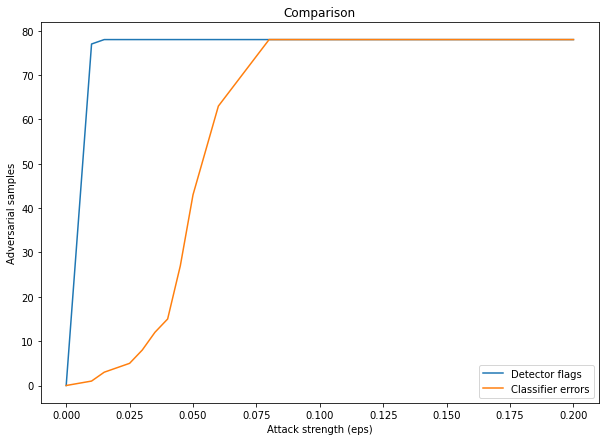

In [ ]:
epsilon = 0.3
eps_step_range = [0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]
iter = 2

num_random_init = 5
nb_flag_adv = []
nb_missclass = []


for eps_step in eps_step_range:
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=eps_step, max_iter=iter, num_random_init = int(num_random_init), verbose=False) 
    x_test_adv = attack.generate(X_test_det)
    nb_flag_adv += [np.sum(np.argmax(detector_pgd.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test_det, axis=1))]
    
eps_step_range = [0] + eps_step_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [0] + nb_missclass


f = plt.figure(figsize=(10, 7))
plt.plot(np.array(eps_step_range), np.array(nb_flag_adv))
plt.plot(np.array(eps_step_range), np.array(nb_missclass))

plt.legend(["Detector flags", "Classifier errors"], loc=0, frameon=True)

plt.xlabel('Attack strength (eps)')
plt.ylabel('Adversarial samples')
plt.title("Comparison")
plt.show()

## ***DEEPFOOL*** DETECTOR 


In [ ]:
num_epsilons = 10
epsilons = [0.000001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

num_max_iter = 4
max_iter = [2,3,5,10]

tot_audios_adv = []
tot_y_adv = []

tot_test_audios_adv = []
tot_test_y_adv = []

rest_of_set=X_train_det
rest_of_y=y_train_det

rest_of_test_set = X_test_det
rest_of_test_y = y_test_det
mi=1
e=1


for iter in max_iter:
  e=1
  for epsilon in epsilons:
    if mi==num_max_iter and e==num_epsilons:
      subset=rest_of_set
      test_subset = rest_of_test_set
      y_subset = rest_of_y
      y_test_det_subset = rest_of_test_y
    else:
      rest_of_set, subset, rest_of_y, y_subset = train_test_split(rest_of_set, rest_of_y, test_size=int(len(X_train_det)/(num_max_iter*num_epsilons)), random_state=42)
      rest_of_test_set, test_subset, rest_of_test_y, y_test_det_subset = train_test_split(rest_of_test_set, rest_of_test_y, test_size=int(len(X_test_det)/(num_max_iter*num_epsilons)), random_state=42)
    
  
    attack = DeepFool(classifier=classifier_logits, epsilon=epsilon, max_iter=iter, verbose=False)

    targeted_labels = target_class*np.ones(y_subset.size)
    targeted_test_labels = target_class*np.ones(y_test_det_subset.size)
    one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=attack_classes) 
    one_hot_targeted_test_labels = tf.keras.utils.to_categorical(targeted_test_labels, num_classes=attack_classes)   
    audios_adv = attack.generate(subset, one_hot_targeted_labels)
    audios_test_adv = attack.generate(test_subset, one_hot_targeted_test_labels)

    if mi==1 and e==1:
      tot_audios_adv = np.concatenate((X_train_det, audios_adv), axis=0)
      tot_test_audios_adv = np.concatenate((X_test_det, audios_test_adv), axis=0)
    else:
      tot_audios_adv = np.concatenate((tot_audios_adv, audios_adv), axis=0)
      tot_test_audios_adv = np.concatenate((tot_test_audios_adv, audios_test_adv), axis=0)
    e=e+1
  mi=mi+1


In [ ]:
num_y = X_train_det.shape[0]

tot_y_adv = np.concatenate((np.array([[1,0]]*num_y), np.array([[0,1]]*num_y)), axis=0)

In [ ]:
fileH5 = 'Datasets/DF_detector_ADV_test.h5'
file = h5py.File(fileH5, "w")
dataset = file.create_dataset("audio", data=tot_test_audios_adv[78:])
file.close()

In [ ]:
file = h5py.File('Datasets/DF_detector_train.h5', "w")
dataset = file.create_dataset("feature", data=tot_audios_adv)
dataset = file.create_dataset("labels", data=tot_y_adv)
file.close()

In [ ]:
f = h5py.File('Datasets/DF_detector_train.h5', 'r')

X_train_det_df = f['feature'][...]
y_train_det_df = f['labels'][...]
f.close()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

detector_df = RandomForestClassifier(n_estimators=150, random_state=42)
detector_df.fit(X_train_det_df, y_train_det_df)

RandomForestClassifier(n_estimators=150, random_state=42)

In [ ]:
pickle.dump(detector_df, open("models/detector_df.h5", "wb"))

In [ ]:
detector_df = pickle.load(open("models/detector_df.h5", "rb"))

In [ ]:
f = h5py.File('Datasets/DF_detector_ADV_test.h5', 'r')

X_adv_df = f['audio'][...]
f.close()

In [ ]:
flag_adv = np.sum(np.argmax(detector_df.predict(X_adv_df), axis=1) == 1)

print("Adversarial test data:")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(len(X_adv_df) - flag_adv))

Adversarial test data:
Flagged: 77
Not flagged: 1


In [ ]:
flag_original = np.sum(np.argmax(detector_df.predict(X_test_det), axis=1) == 1)

print("Original test data:")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(len(X_test_det) - flag_original))

Original test data:
Flagged: 0
Not flagged: 78


###CERTIFIED DEFENCE

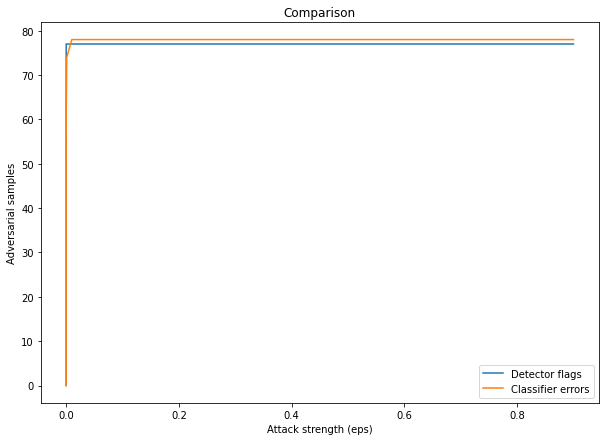

In [ ]:
eps_range = [0.000001,0.0001,0.0001,0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
iter = 5

nb_flag_adv = []
nb_missclass = []


for eps in eps_range:
    attack = DeepFool(classifier=classifier_logits, epsilon=eps, max_iter=iter, verbose=False)
    x_test_adv = attack.generate(X_test_det)
    nb_flag_adv += [np.sum(np.argmax(detector_df.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test_det, axis=1))]
    
eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [0] + nb_missclass


f = plt.figure(figsize=(10, 7))
plt.plot(np.array(eps_range), np.array(nb_flag_adv))
plt.plot(np.array(eps_range), np.array(nb_missclass))

plt.legend(["Detector flags", "Classifier errors"], loc=0, frameon=True)

plt.xlabel('Attack strength (eps)')
plt.ylabel('Adversarial samples')
plt.title("Comparison")
plt.show()

## ***CARLINI WAGNER*** DETECTOR

In [ ]:
bss = 1
confidence = 0.9 
max_iterations = [6,7,10,12,15,18,20]
learning_rate = 0.0001 
initial_const = 1
target_class_cw = 1
attack_classes_cw = 2
num_m_i = len(max_iterations)

tot_audios_adv = []
tot_y_adv = []

tot_test_audios_adv = []
tot_test_y_adv = []

rest_of_set=X_train_det
rest_of_y=y_train_det

rest_of_test_set = X_test_det
rest_of_test_y = y_test_det

c=1

for m_i in tqdm(max_iterations):
  
  if c==num_m_i:
    subset=rest_of_set
    test_subset = rest_of_test_set
    y_subset = rest_of_y
    y_test_det_subset = rest_of_test_y
  else:
    rest_of_set, subset, rest_of_y, y_subset = train_test_split(rest_of_set, rest_of_y, test_size=int(len(X_train_det)/num_m_i), random_state=42)
    rest_of_test_set, test_subset, rest_of_test_y, y_test_det_subset = train_test_split(rest_of_test_set, rest_of_test_y, test_size=int(len(X_test_det)/num_m_i), random_state=42)
  
  attack = CarliniL2Method(classifier=classifier_logits, binary_search_steps=bss, confidence=confidence, max_iter=m_i, learning_rate=learning_rate, initial_const=initial_const, targeted=True)
  
  targeted_labels = target_class*np.ones(y_subset.size)
  targeted_test_labels = target_class*np.ones(y_test_det_subset.size)

  one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=attack_classes)  
  one_hot_targeted_test_labels = tf.keras.utils.to_categorical(targeted_test_labels, num_classes=attack_classes)  

  audios_adv = attack.generate(subset, one_hot_targeted_labels)
  audios_test_adv = attack.generate(test_subset, one_hot_targeted_test_labels)
  

  if c==1:
    tot_audios_adv = np.concatenate((X_train_det, audios_adv), axis=0)
    tot_test_audios_adv = np.concatenate((X_test_det, audios_test_adv), axis=0)
  else:
    tot_audios_adv = np.concatenate((tot_audios_adv, audios_adv), axis=0)
    tot_test_audios_adv = np.concatenate((tot_test_audios_adv, audios_test_adv), axis=0)
  c=c+1

  0%|          | 0/7 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/88 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/11 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:07<00:46,  7.74s/it]

C&W L_2:   0%|          | 0/88 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/11 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:14<00:36,  7.33s/it]

C&W L_2:   0%|          | 0/88 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/11 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:24<00:33,  8.39s/it]

C&W L_2:   0%|          | 0/88 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/11 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:35<00:28,  9.60s/it]

C&W L_2:   0%|          | 0/88 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/11 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:49<00:22, 11.03s/it]

C&W L_2:   0%|          | 0/88 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/11 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [01:05<00:12, 12.66s/it]

C&W L_2:   0%|          | 0/88 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 7/7 [01:22<00:00, 11.83s/it]


In [ ]:
num_y = X_train_det.shape[0]
tot_y_adv = np.concatenate((np.array([[1,0]]*num_y), np.array([[0,1]]*num_y)), axis=0)

In [ ]:
fileH5 = 'Datasets/CW_detector_ADV_test.h5'
file = h5py.File(fileH5, "w")
dataset = file.create_dataset("audio", data=tot_test_audios_adv[78:])
file.close()

In [ ]:
file = h5py.File('Datasets/CW_detector_train.h5', "w")
dataset = file.create_dataset("feature", data=tot_audios_adv)
dataset = file.create_dataset("labels", data=tot_y_adv)
file.close()

In [ ]:
f = h5py.File('Datasets/CW_detector_train.h5', 'r')

X_train_det_cw = f['feature'][...]
y_train_det_cw = f['labels'][...]
f.close()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

detector_cw = RandomForestClassifier(n_estimators=100, random_state=42)
detector_cw.fit(X_train_det_cw, y_train_det_cw)

RandomForestClassifier(random_state=42)

In [ ]:
pickle.dump(detector_cw, open("models/detector_cw.h5", "wb"))

In [ ]:
detector_cw = pickle.load(open("models/detector_cw.h5", "rb"))

In [ ]:
f = h5py.File('Datasets/CW_detector_ADV_test.h5', 'r')

X_adv_cw = f['audio'][...]
f.close()

In [ ]:
flag_adv = np.sum(np.argmax(detector_cw.predict(X_adv_cw), axis=1) == 1)

print("Adversarial test data:")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(len(X_adv_cw) - flag_adv))

Adversarial test data:
Flagged: 73
Not flagged: 5


In [ ]:
flag_original = np.sum(np.argmax(detector_cw.predict(X_test_det), axis=1) == 1)

print("Original test data:")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(len(X_test_det) - flag_original))

Original test data:
Flagged: 1
Not flagged: 77


###CERTIFIED DEFENCE

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/78 [00:00<?, ?it/s]

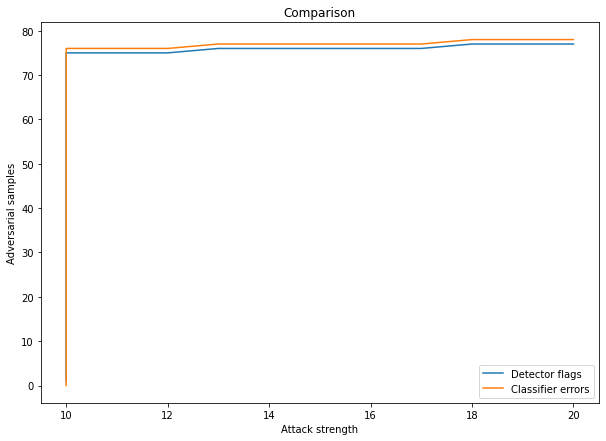

In [ ]:
max_iterations = [10,11,12,13,14,15,16,17,18,19,20]
nb_flag_adv = []
nb_missclass = []


for m_i in max_iterations:
    attack = CarliniL2Method(classifier=classifier_logits, binary_search_steps=bss, confidence=confidence, max_iter=m_i, learning_rate=learning_rate, initial_const=initial_const)
    x_test_adv = attack.generate(X_test_det)
    nb_flag_adv += [np.sum(np.argmax(detector_cw.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test_det, axis=1))]

max_iterations = [10] + max_iterations
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [0] + nb_missclass


f = plt.figure(figsize=(10, 7))
plt.plot(np.array(max_iterations), np.array(nb_flag_adv))
plt.plot(np.array(max_iterations), np.array(nb_missclass))

plt.legend(["Detector flags", "Classifier errors"], loc=0, frameon=True)

plt.xlabel('Attack strength')
plt.ylabel('Adversarial samples')
plt.title("Comparison")
plt.show()

## GENERAL EVALUATION

###WHITE BOX

In [ ]:
all_audios_not_shuffled = np.concatenate((X_test_det, X_adv_fgsm, X_adv_bim, X_adv_pgd, X_adv_df, X_adv_cw), axis=0)
num_y = X_test.shape[0]

In [ ]:
all_y_for_model_not_shuffled = np.concatenate((y_test_det, y_test_det, y_test_det, y_test_det, y_test_det, y_test_det), axis=0)

all_audios_for_model, all_y_for_model = shuffle(all_audios_not_shuffled, all_y_for_model_not_shuffled, random_state=42)


White Box results Without Detector - Loss: 6.069918208652073 - Accuracy: 0.2735042870044708%

              precision    recall  f1-score   support

           0       1.00      0.27      0.43       468
           1       0.00      0.00      0.00         0

    accuracy                           0.27       468
   macro avg       0.50      0.14      0.21       468
weighted avg       1.00      0.27      0.43       468

Accuracy = 0.27350427350427353


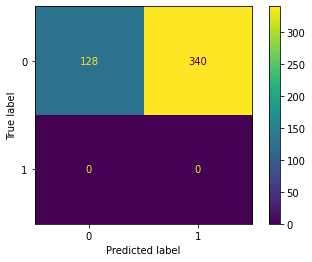

In [ ]:
test_results = whiteBox.evaluate(all_audios_for_model, all_y_for_model, verbose=1)
print(f'\nWhite Box results Without Detector - Loss: {test_results[0]} - Accuracy: {test_results[1]}%\n')


y_pred = de_one_hot(whiteBox.predict(all_audios_for_model))
all_y_for_model = de_one_hot(all_y_for_model)

cnf_mat = confusion_matrix(all_y_for_model.tolist(), y_pred.tolist())
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat)
disp.plot()
print(classification_report(all_y_for_model.tolist(), y_pred.tolist()))
print("Accuracy = "+ str(accuracy_score(all_y_for_model.tolist(), y_pred.tolist())))

###DETECTOR

In [ ]:
all_y_for_detector_not_shuffled = np.concatenate((np.array([1]*num_y), np.array([0]*num_y), np.array([0]*num_y), np.array([0]*num_y), np.array([0]*num_y), np.array([0]*num_y)), axis=0)

all_audios_for_detector, all_y_for_detector = shuffle(all_audios_not_shuffled, all_y_for_detector_not_shuffled, random_state=42)

In [ ]:
predictions = [detector.predict(all_audios_for_detector) for detector in [detector_fgsm, detector_bim, detector_pgd, detector_df, detector_cw]]

In [ ]:
filtered_audios=[]
filtered_y=[]
for i in range (0, len(all_audios_for_detector)):
  c=0
  if np.argmax(predictions[0][i]) == 0:
    c=c+1
  if np.argmax(predictions[1][i]) == 0:
    c=c+1
  if np.argmax(predictions[2][i]) == 0:
    c=c+1
  if np.argmax(predictions[3][i]) == 0:
    c=c+1
  if np.argmax(predictions[4][i]) == 0:
    c=c+1
  if c == 5:
    audio_to_keep=all_audios_for_detector[i]
    y_to_keep=all_y_for_model[i]
    filtered_audios.append(audio_to_keep)
    filtered_y.append(y_to_keep)
filtered_audios=np.array(filtered_audios)


White Box results With Detector - Loss: 0.02455382282426069 - Accuracy: 0.9890109896659851

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        91
           1       0.00      0.00      0.00         0

    accuracy                           0.99        91
   macro avg       0.50      0.49      0.50        91
weighted avg       1.00      0.99      0.99        91

Accuracy = 0.989010989010989


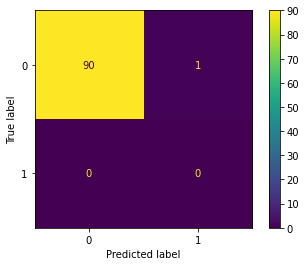

In [ ]:
test_results = whiteBox.evaluate(filtered_audios, to_categorical(filtered_y, 2), verbose=1)
print(f'\nWhite Box results With Detector - Loss: {test_results[0]} - Accuracy: {test_results[1]}\n')


y_pred = de_one_hot(whiteBox.predict(filtered_audios))

cnf_mat = confusion_matrix(filtered_y, y_pred.tolist())
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat)
disp.plot()
print(classification_report(filtered_y, y_pred.tolist()))
print("Accuracy = "+ str(accuracy_score(filtered_y, y_pred.tolist())))


White Box results with only original samples - Loss: 0.010878283584203858 - Accuracy: 1.0%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

Accuracy = 1.0


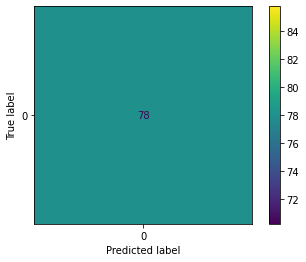

In [ ]:
test_results = whiteBox.evaluate(X_test_det, to_categorical(y_test, 2), verbose=1)
print(f'\nWhite Box results with only original samples - Loss: {test_results[0]} - Accuracy: {test_results[1]}%\n')


y_pred = de_one_hot(whiteBox.predict(X_test_det))
y_test_det = de_one_hot(y_test_det)


cnf_mat = confusion_matrix(y_test_det.tolist(), y_pred.tolist())
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat)
disp.plot()
print(classification_report(y_test_det.tolist(), y_pred.tolist()))
print("Accuracy = "+ str(accuracy_score(y_test_det.tolist(), y_pred.tolist())))